In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from utils.utils import load_data, remove_zero_features, load_confounders, standardize
from utils.utils import load_measurement_labels, load_feature_subset, load_roi_labels

import statsmodels.api as sm
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, balanced_accuracy_score

In [2]:
plot_path = 'plots/'

In [3]:
N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 8


---

In [4]:
# Load data for classification task
subject_data, features, diagnoses = load_data('classification')

In [7]:
C = load_confounders(subject_data)
F = remove_zero_features(features.iloc[:,1:])
D = diagnoses.iloc[:,1:]

In [8]:
# Deconfounding: regress C out of D
reg = LinearRegression().fit(C, D)
D_deconf = D - reg.predict(C)

---

## 1. Univariate analysis

### 1.1. Correlation

#### 1.1.1. Plot correltion between confounders and diagnoses before and after deconfounding

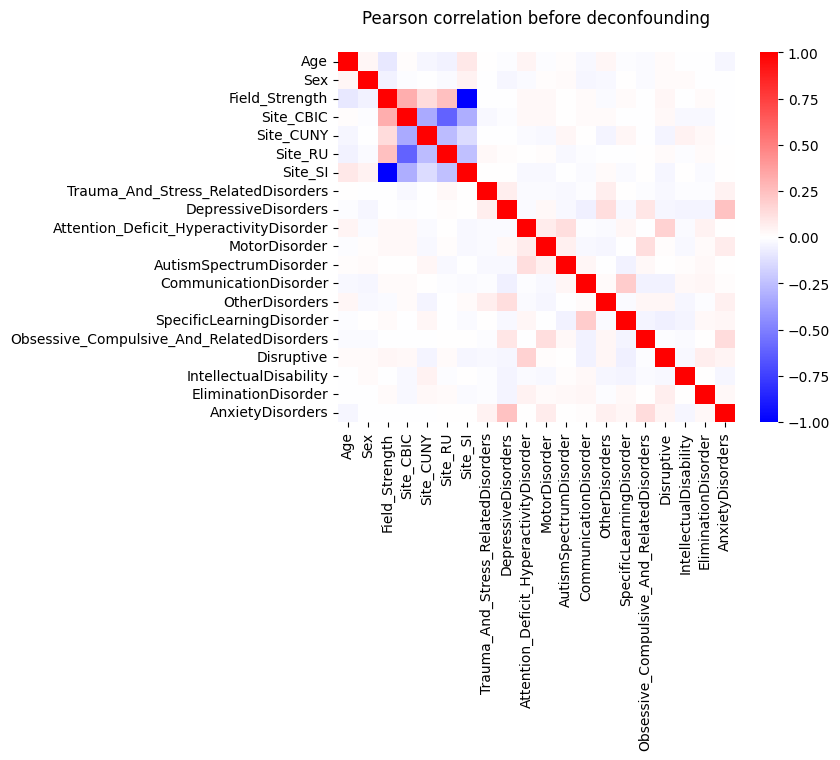

In [11]:
# Plot Pearson correlation between C and D
sns.heatmap(pd.concat([C,D], axis=1).corr('pearson'), cmap='bwr', center=0)
plt.title("Pearson correlation before deconfounding\n")
plt.savefig(plot_path + 'correlation_before.png', bbox_inches='tight')

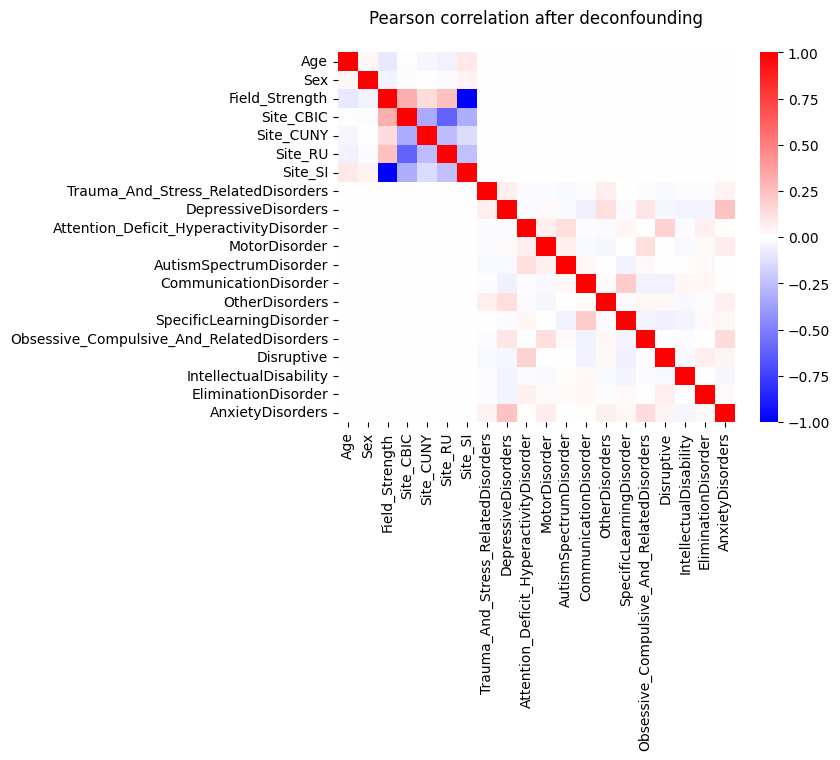

In [12]:
# Plot Pearson correlation between C and D
sns.heatmap(pd.concat([C,D_deconf], axis=1).corr('pearson'), cmap='bwr', center=0)
plt.title("Pearson correlation after deconfounding\n")
plt.savefig(plot_path + 'correlation_after.png', bbox_inches='tight')

#### 1.1.2. Plot correltion between global morphometric features and confounders

In [13]:
global_msnts, aseg_msnts, aparc_msnts = load_measurement_labels()

Text(0.5, 1.0, 'Pearson correlation between confounders and global features\n')

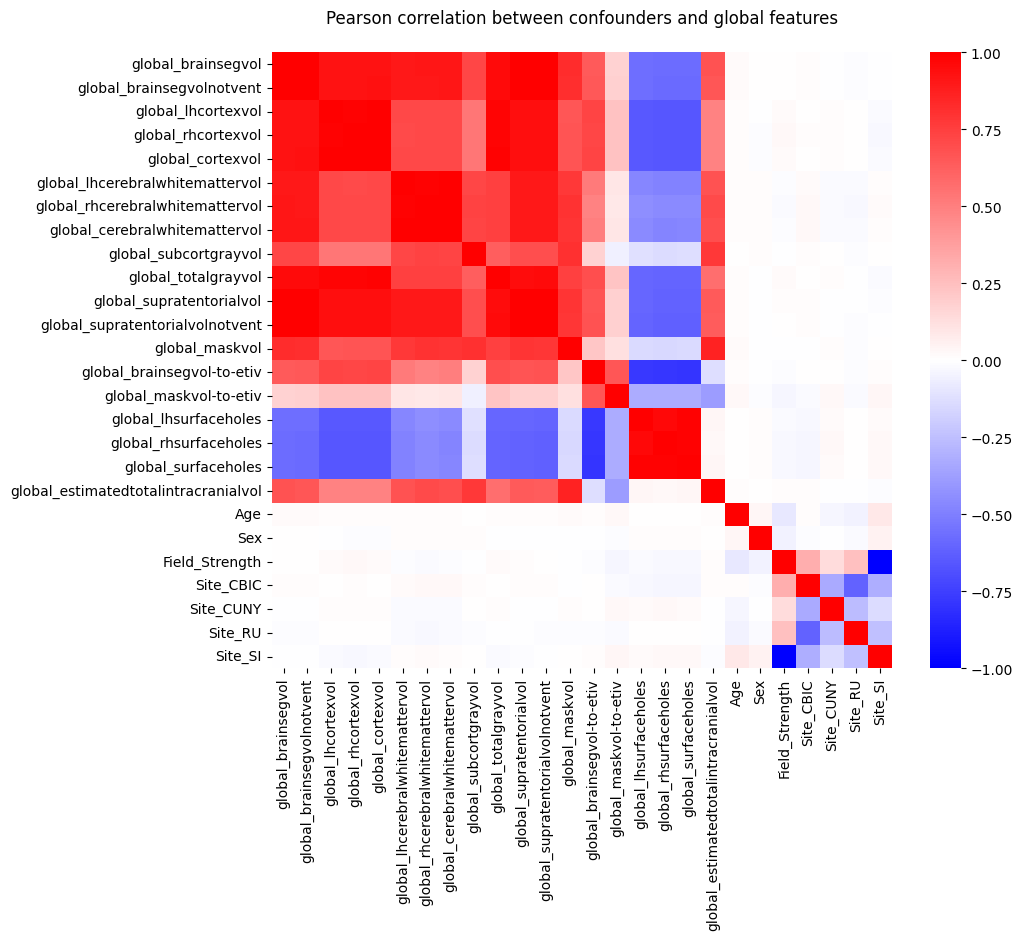

In [14]:
# Global measures
F1 = load_feature_subset(features, 'global', global_msnts)
plt.figure(1,(10,8))
sns.heatmap(pd.concat([F1,C], axis=1).corr('pearson'), cmap='bwr', center=0)
plt.title("Pearson correlation between confounders and global features\n")

#### 1.1.3. Plot correltion between subcortical morphometric features and confounders

Text(0.5, 1.0, 'Pearson correlation between confounders and aseg rois for feature volume \n')

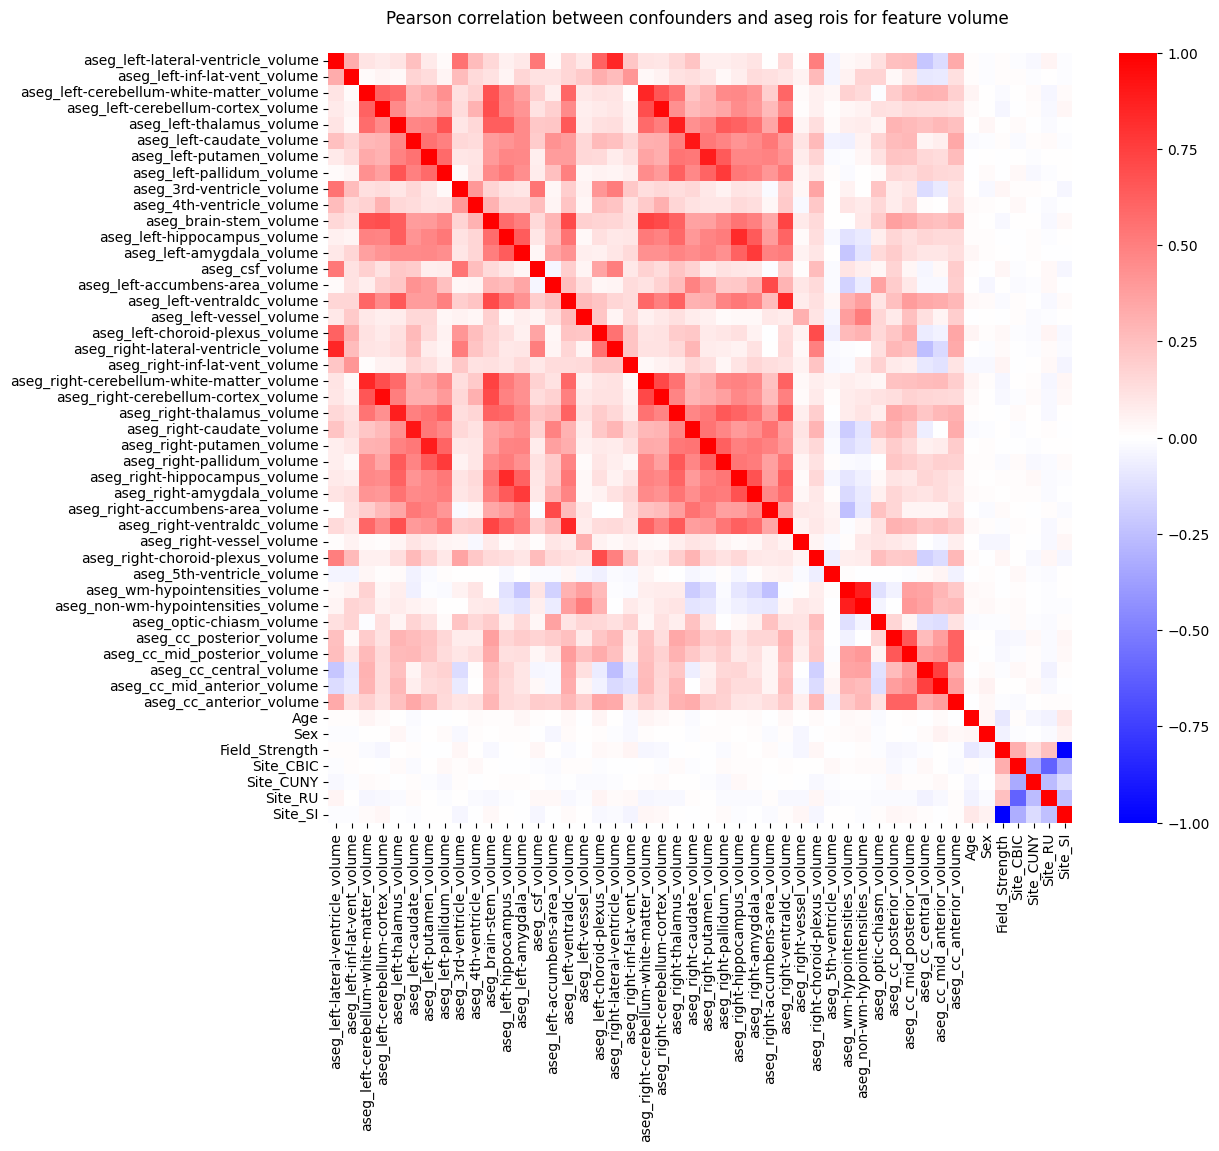

In [15]:
# Subcortical measures
index = 6 # [0 .. 6]
F2 = load_feature_subset(features, 'aseg', [aseg_msnts[index]], -1)
F2 = F2.drop(F2.columns[F2.eq(0).all()], axis=1)
plt.figure(1,(12,10))
sns.heatmap(pd.concat([F2,C], axis=1).corr('pearson'), cmap='bwr', center=0)
plt.title(f"Pearson correlation between confounders and aseg rois for feature {aseg_msnts[index]} \n")

#### 1.1.4. Plot correltion between cortical morphometric features and confounders

In [16]:
# Cortical measures
index = 0 # [0 .. 8]

Text(0.5, 1.0, 'Pearson correlation between confounders and aparc_lh rois for feature volume \n')

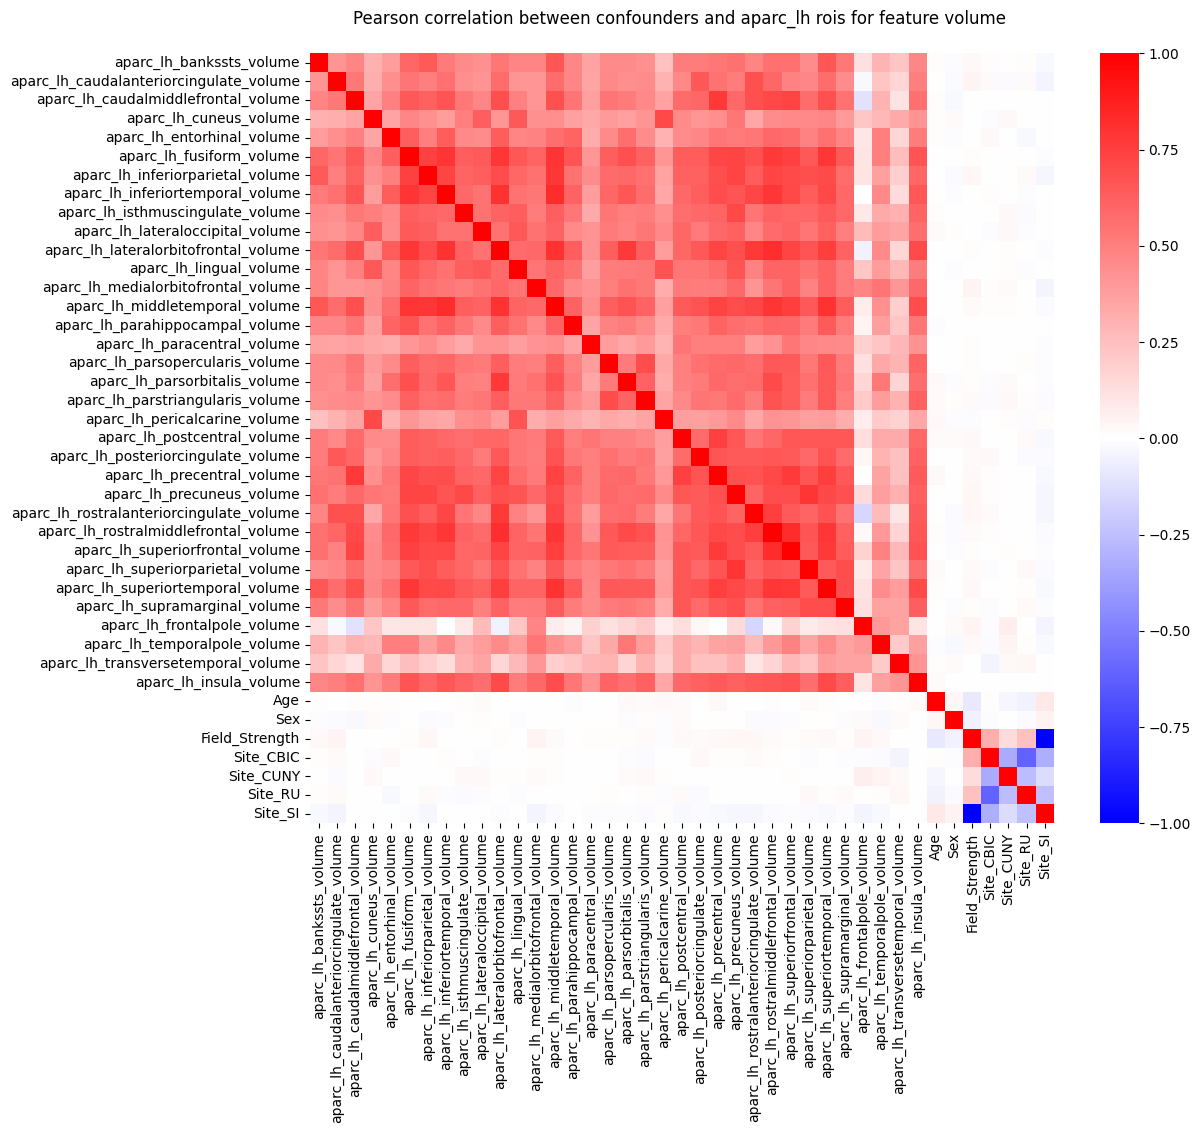

In [17]:
# lh
F3l = load_feature_subset(features, 'aparc_lh', [aparc_msnts[index]], -1)
F3l = F3l.drop(F3l.columns[F3l.eq(0).all()], axis=1)
plt.figure(1,(12,10))
sns.heatmap(pd.concat([F3l,C], axis=1).corr('pearson'), cmap='bwr', center=0)
plt.title(f"Pearson correlation between confounders and aparc_lh rois for feature {aparc_msnts[index]} \n")

Text(0.5, 1.0, 'Pearson correlation between confounders and aparc_rh rois for feature volume \n')

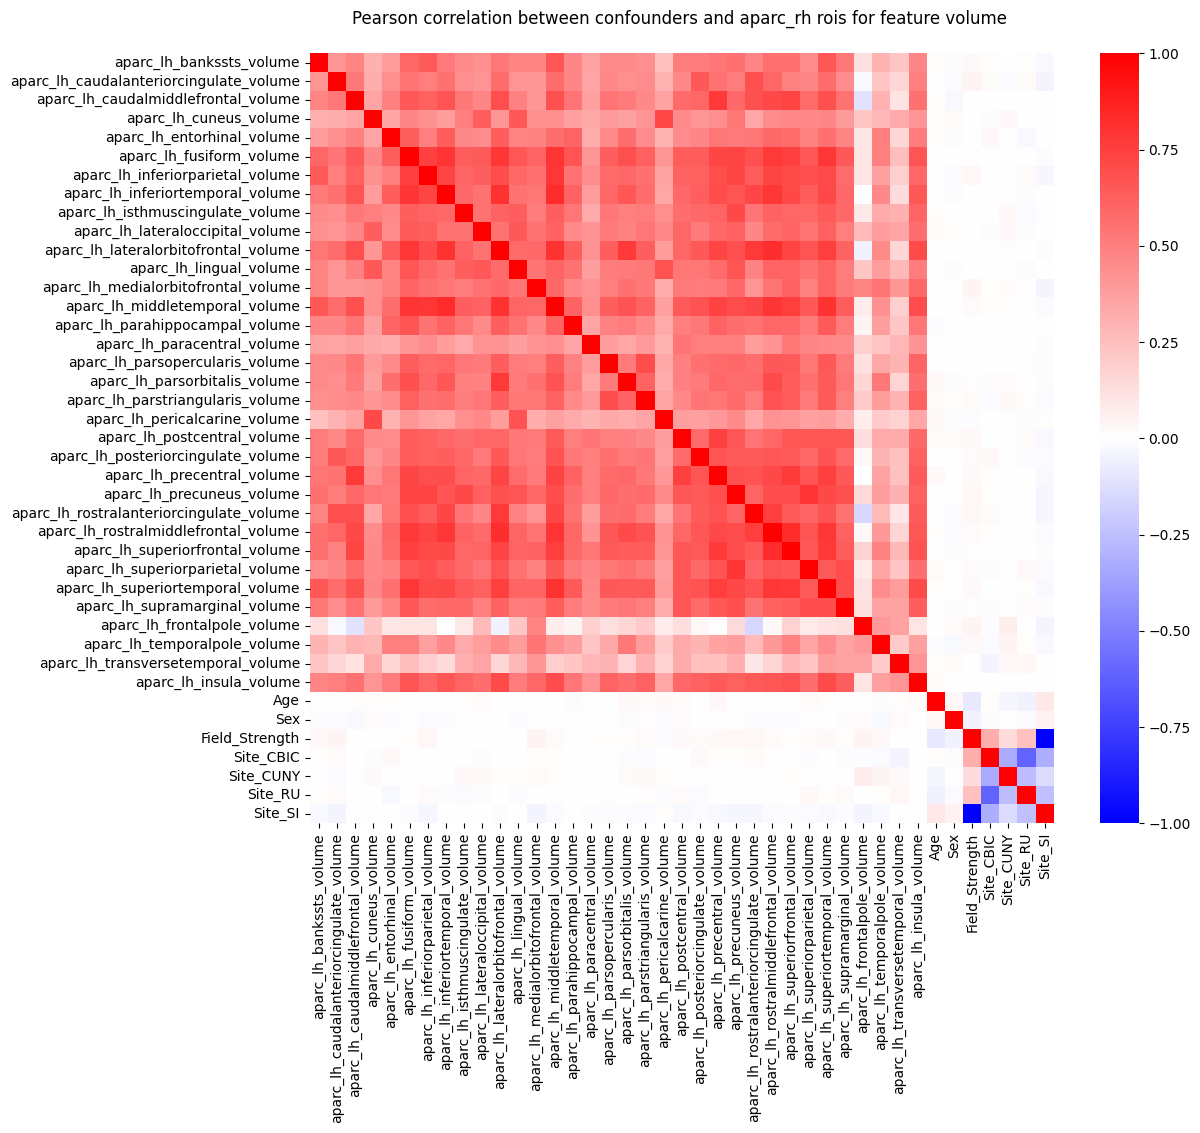

In [18]:
# rh
F3r = load_feature_subset(features, 'aparc_lh', [aparc_msnts[index]], -1)
F3r = F3r.drop(F3r.columns[F3r.eq(0).all()], axis=1)
plt.figure(1,(12,10))
sns.heatmap(pd.concat([F3r,C], axis=1).corr('pearson'), cmap='bwr', center=0)
plt.title(f"Pearson correlation between confounders and aparc_rh rois for feature {aparc_msnts[index]} \n")

#### 1.1.5. Plot correltion between global morphometric features and diagnoses

Text(0.5, 1.0, 'Pearson correlation between diagnoses and global features\n')

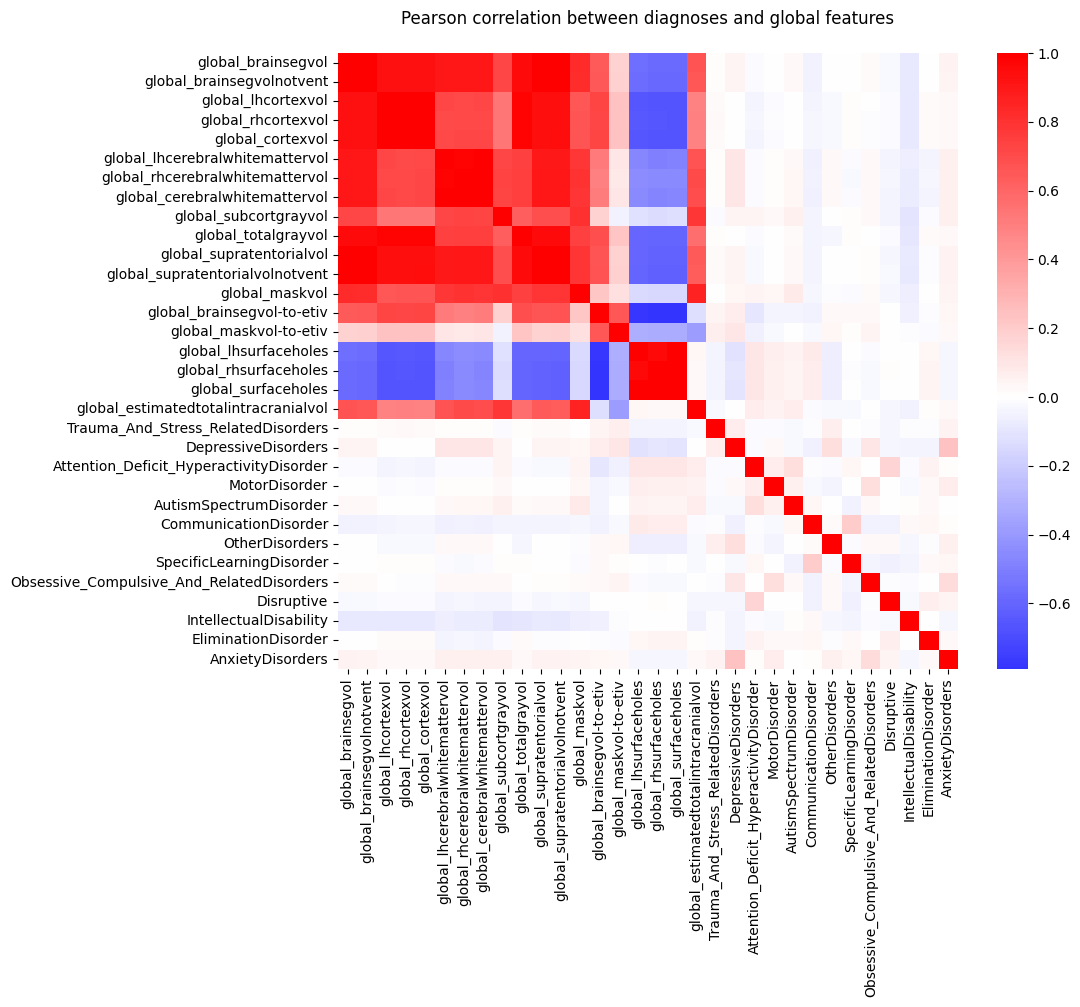

In [19]:
# Global measures
F1 = load_feature_subset(features, 'global', global_msnts)
plt.figure(1,(10,8))
sns.heatmap(pd.concat([F1,D_deconf], axis=1).corr('pearson'), cmap='bwr', center=0)
plt.title("Pearson correlation between diagnoses and global features\n")

#### 1.1.6. Plot correltion between subcortical morphometric features and diagnoses (deconfounded)

Text(0.5, 1.0, 'Pearson correlation between diagnoses and aseg rois for feature volume \n')

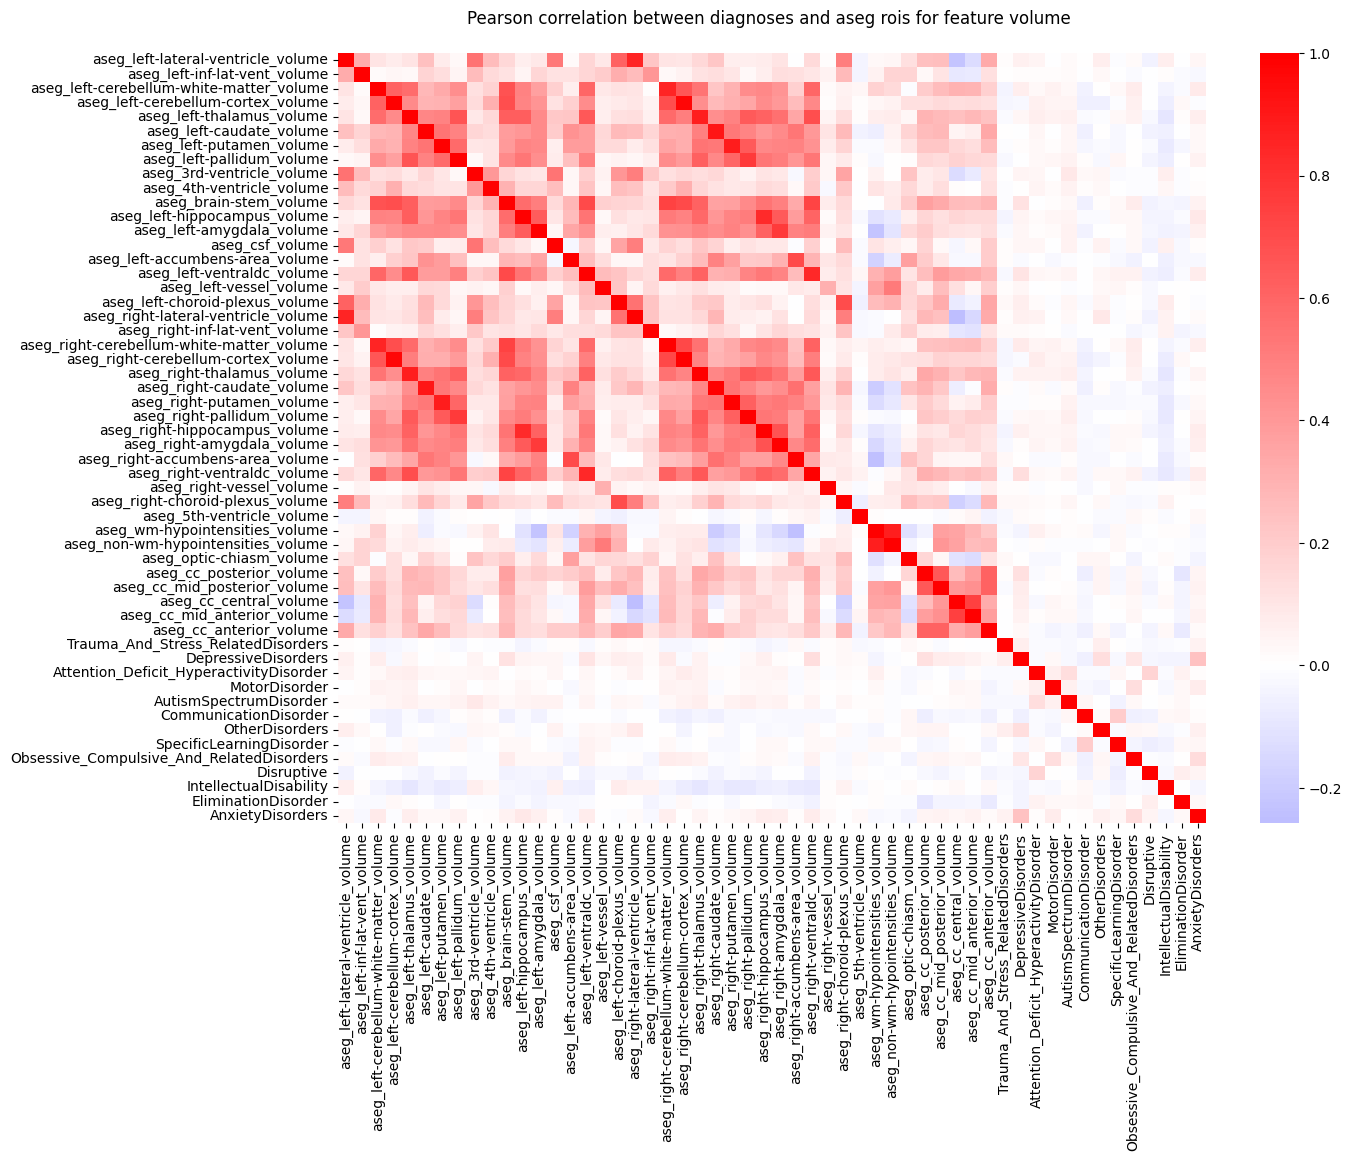

In [22]:
# Subcortical measures
index = 6 # [0 .. 6]
F2 = load_feature_subset(features, 'aseg', [aseg_msnts[index]], -1)
F2 = F2.drop(F2.columns[F2.eq(0).all()], axis=1)
plt.figure(1,(14,10))
sns.heatmap(pd.concat([F2,D_deconf], axis=1).corr('pearson'), cmap='bwr', center=0)
plt.title(f"Pearson correlation between diagnoses and aseg rois for feature {aseg_msnts[index]} \n")

#### 1.1.7. Plot correltion between cortical morphometric features and diagnoses

In [23]:
# Cortical measures
index = 0 # [0 .. 8]

Text(0.5, 1.0, 'Pearson correlation between diagnoses and aparc_lh rois for feature volume \n')

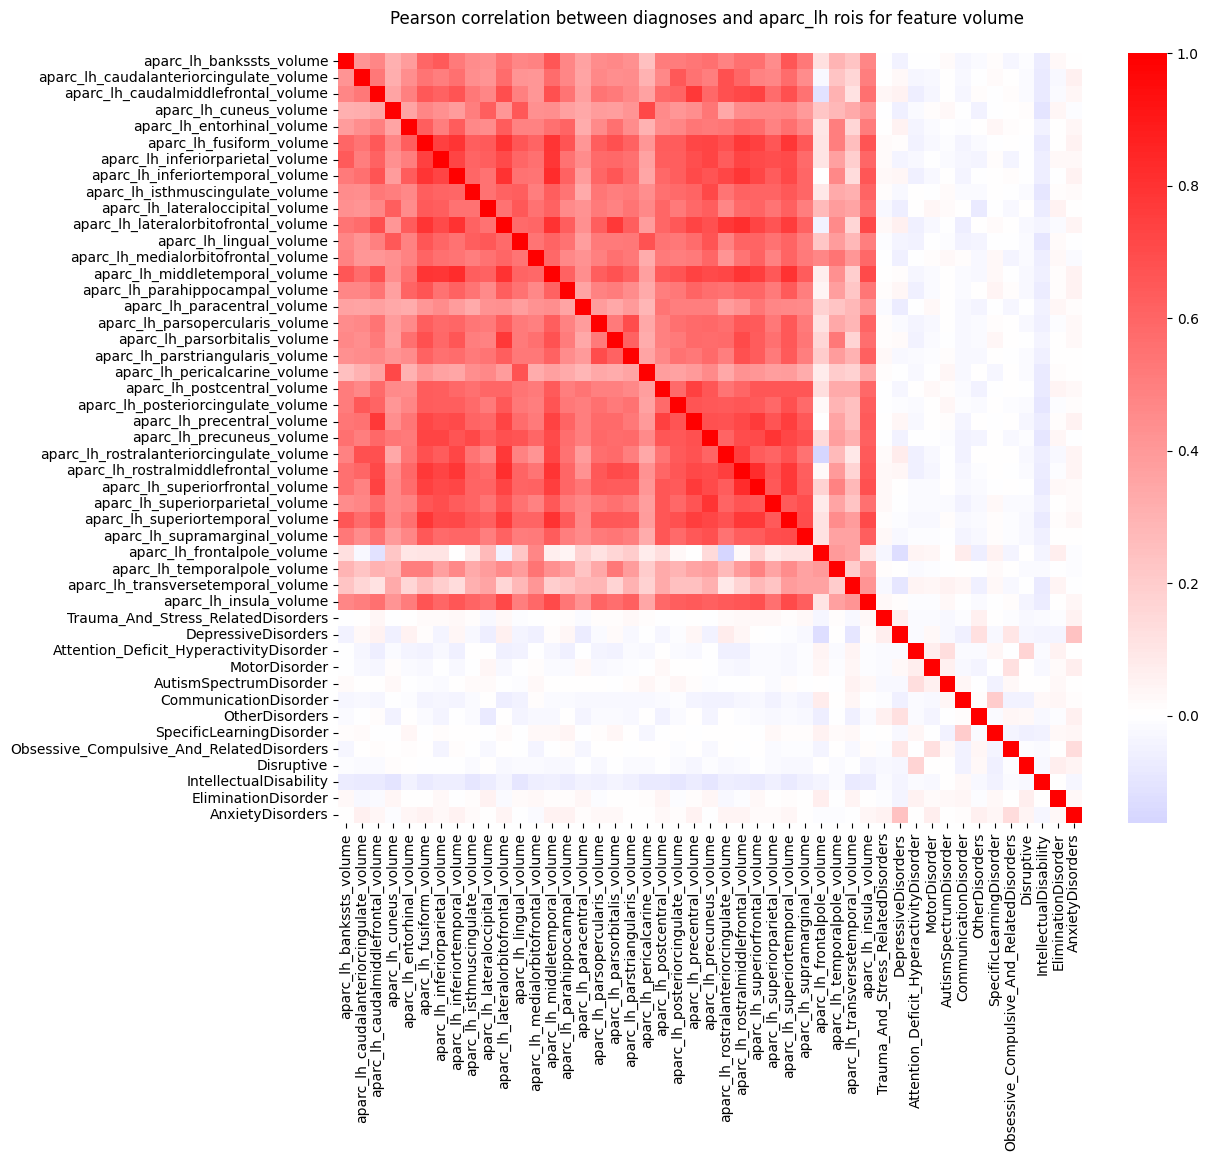

In [24]:
# lh
F3l = load_feature_subset(features, 'aparc_lh', [aparc_msnts[0]], -1)
F3l = F3l.drop(F3l.columns[F3l.eq(0).all()], axis=1)
plt.figure(1,(12,10))
sns.heatmap(pd.concat([F3l,D_deconf], axis=1).corr('pearson'), cmap='bwr', center=0)
plt.title(f"Pearson correlation between diagnoses and aparc_lh rois for feature {aparc_msnts[index]} \n")

Text(0.5, 1.0, 'Pearson correlation between diagnoses and aparc_rh rois for feature volume \n')

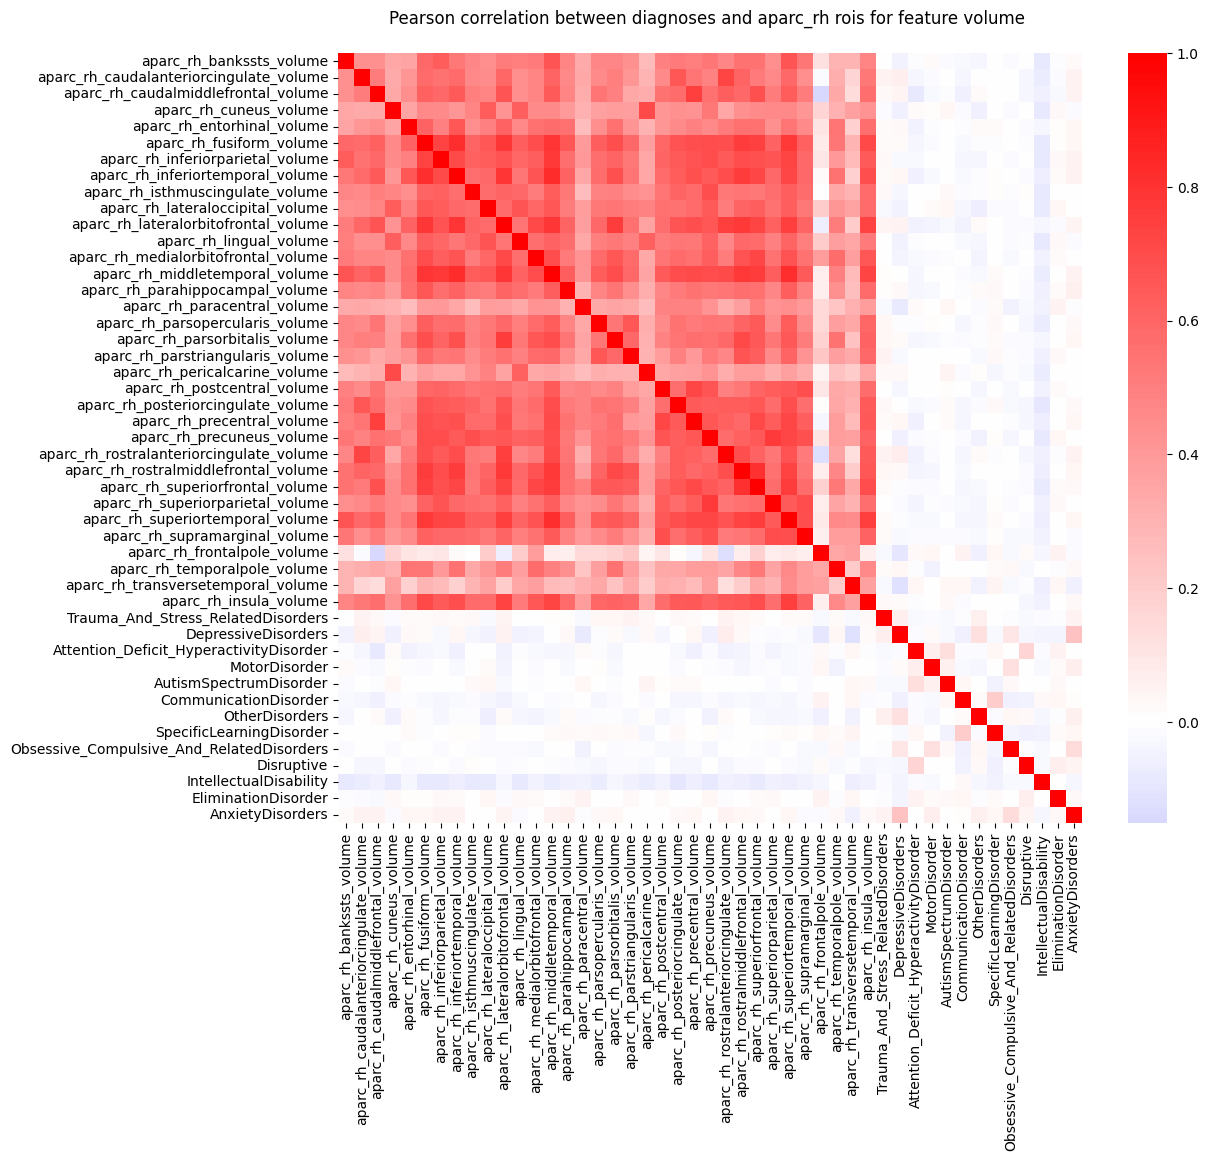

In [59]:
# rh
F3r = load_feature_subset(features, 'aparc_rh', [aparc_msnts[0]], -1)
F3r = F3r.drop(F3r.columns[F3r.eq(0).all()], axis=1)
plt.figure(1,(12,10))
sns.heatmap(pd.concat([F3r,D_deconf], axis=1).corr('pearson'), cmap='bwr', center=0)
plt.title(f"Pearson correlation between diagnoses and aparc_rh rois for feature {aparc_msnts[index]}\n")

### 1.2. P-values for confounders
Plot significant p-values for confounders explaining features. For every combination of confounder and feature (univariate setting), a linear regression model is fitted. Input and output variables are standardized prior to model fitting. The p-values are derived from the regression coefficients using a t-test. The feature classes include global, aseg, aparc_lh and aparc_rh. 

In [25]:
C_ = standardize(C)

In [26]:
aseg_roi_labels, aparc_roi_labels = load_roi_labels()

#### 1.2.1. Global features

In [65]:
p_dict = {}

for c in C_:
    
    c_list = []

    for f in global_msnts:
        y = load_feature_subset(features, 'global', [f])
        y = standardize(y) # standardize freesurfer variables
        c_ =  sm.add_constant(C_[c])
        est = sm.OLS(y, c_)
        est = est.fit(disp=0)
        c_list.append(est.pvalues[1])

    p_dict[c] = c_list

In [66]:
P = pd.DataFrame.from_dict(p_dict, orient='index', columns=global_msnts)
# Replace zero values with small positive constant to avoid numerical problems
P = P.replace(0, 1e-15)

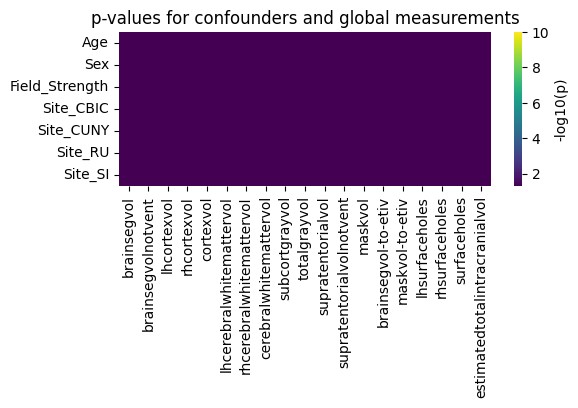

In [70]:
# Plot
plt.figure(1,(6,2))
sns.heatmap(-np.log10(P), cmap='viridis', vmin=-np.log10(0.05), vmax=10, fmt=".2f", cbar_kws={'label': '-log10(p)'})
plt.title("p-values for confounders and global measurements")
plt.savefig(plot_path + 'pvalues_confounder_global.png', bbox_inches='tight')

#### 1.2.2. Subcortical features

In [72]:
f_dicts = []

for f in aseg_msnts:
    
    f_dict = {}
    Y = load_feature_subset(features, 'aseg',[f],-1)
    Y = standardize(Y) # standardize freesurfer variables
    
    for c in C_:
        c_list = []
        
        for roi in Y:
            c_ =  sm.add_constant(C_[c])
            est = sm.OLS(Y[roi], c_)
            est = est.fit(disp=0)
            c_list.append(est.pvalues[1])
            
    
        f_dict[c] = c_list
    f_dicts.append(f_dict)

In [73]:
aseg_roi_labels_copy = aseg_roi_labels.copy()
to_remove = ['left-wm-hypointensities', 'right-wm-hypointensities', 'left-non-wm-hypointensities', 'right-non-wm-hypointensities']
[aseg_roi_labels_copy.remove(x) for x in to_remove]

[None, None, None, None]

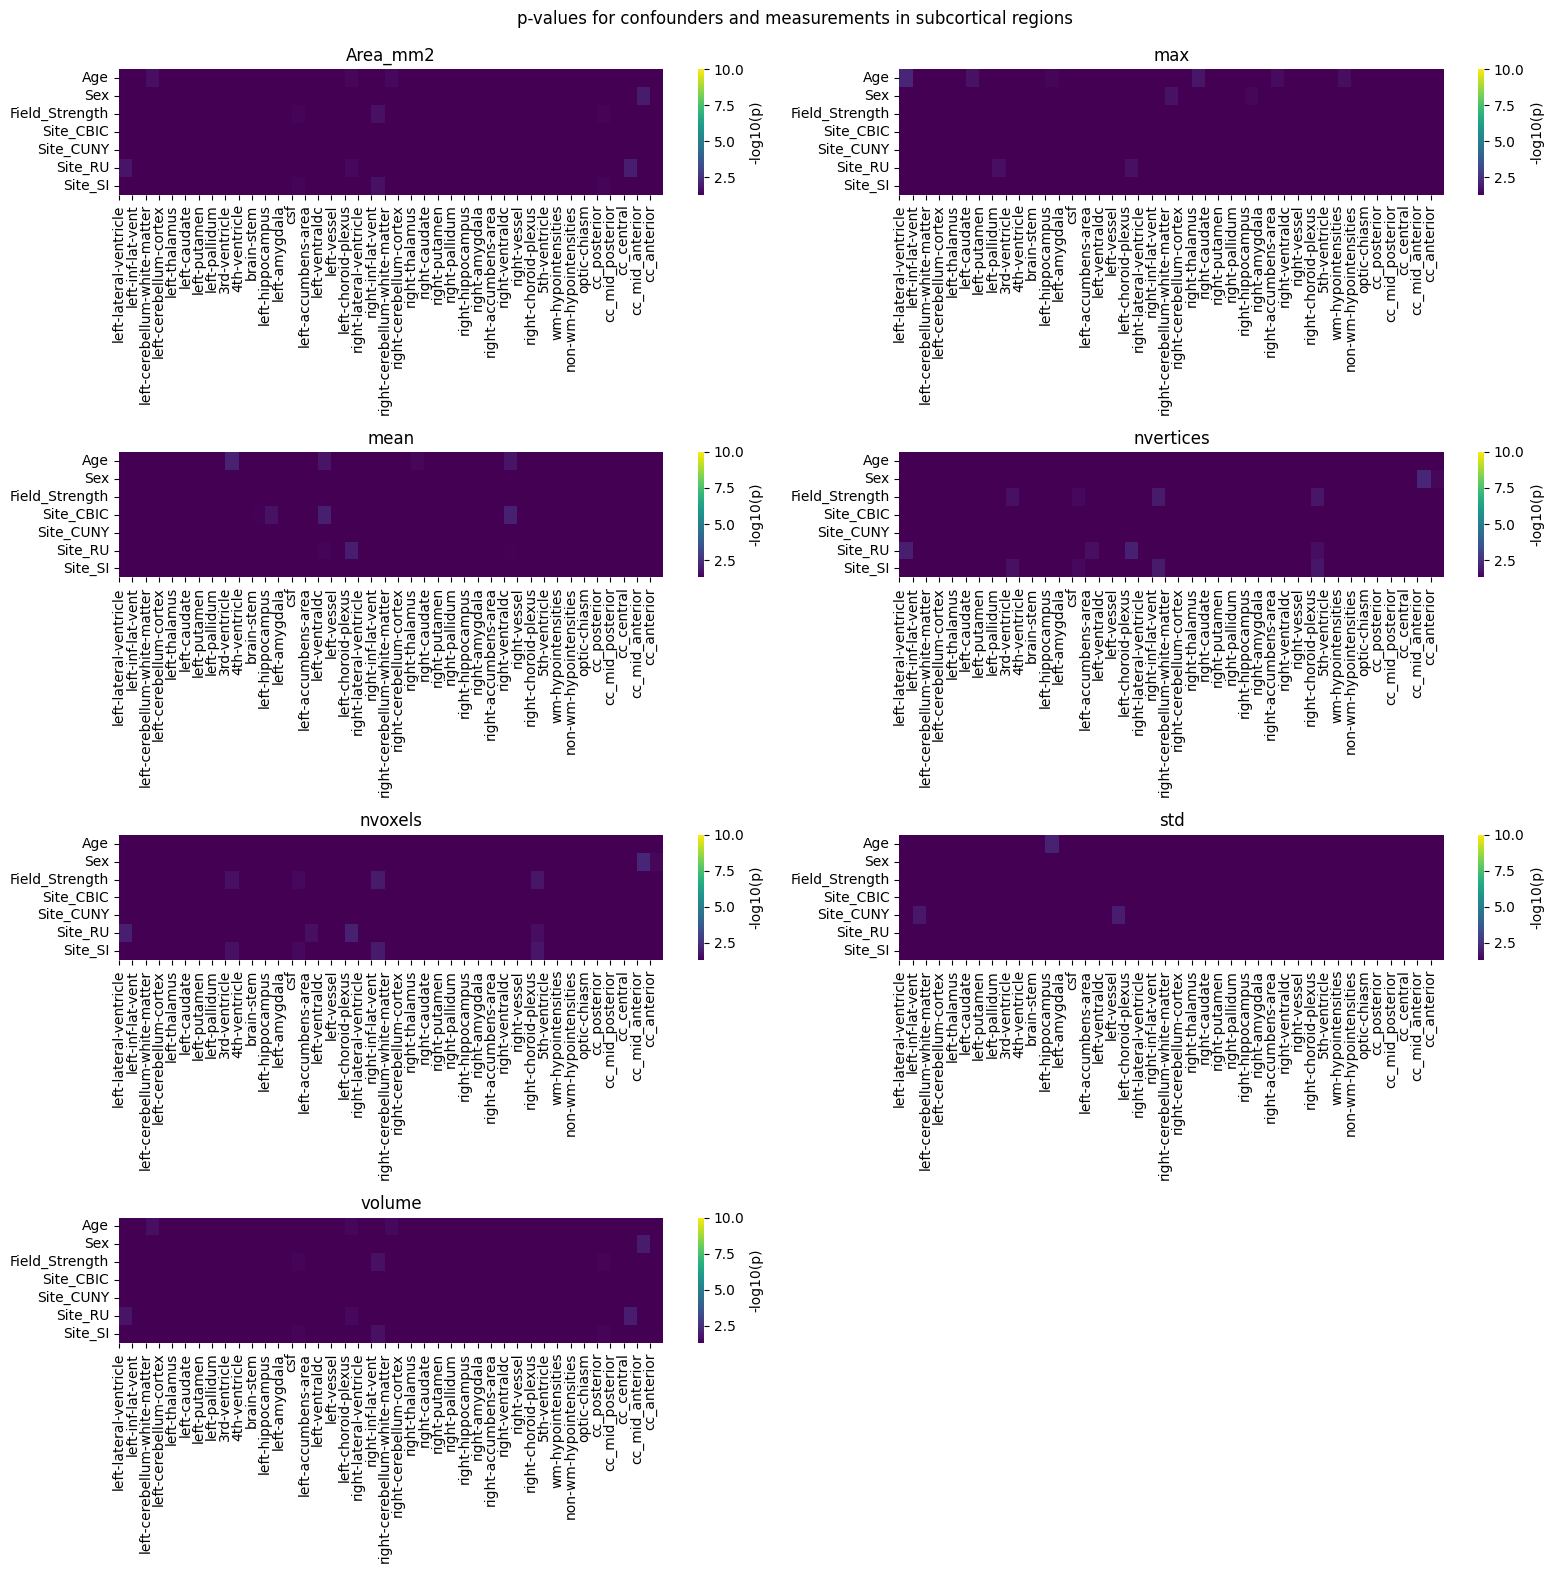

In [74]:
plt.figure(1,(16,16))

for index in range(len(aseg_msnts)):
    P = pd.DataFrame.from_dict(f_dicts[index], orient='index', columns=aseg_roi_labels)
    P = P.replace(0, 1e-15)
    P = P.drop(to_remove, axis=1)
    plt.subplot(4,2,index+1)
    sns.heatmap(-np.log10(P), cmap='viridis', vmin=-np.log10(0.05), vmax=10, fmt=".2f", cbar_kws={'label': '-log10(p)'})
    plt.xticks(range(len(aseg_roi_labels_copy)),aseg_roi_labels_copy)
    plt.title(f"{aseg_msnts[index]}")

plt.suptitle("p-values for confounders and measurements in subcortical regions\n")
plt.tight_layout()

plt.savefig(f'{plot_path}pvalues_confounder_aseg.png', bbox_inches='tight')

#### 1.2.3. Cortical features

lh

In [75]:
f_dicts = []

for f in aparc_msnts:
    
    f_dict = {}
    Y = load_feature_subset(features, 'aparc_lh', [f], -1)
    Y = standardize(Y)
    
    for c in C_:
        c_list = []
        
        for roi in Y:
            c_ =  sm.add_constant(C_[c])
            est = sm.OLS(Y[roi], c_)
            est = est.fit(disp=0)
            c_list.append(est.pvalues[1])
    
        f_dict[c] = c_list
    f_dicts.append(f_dict)


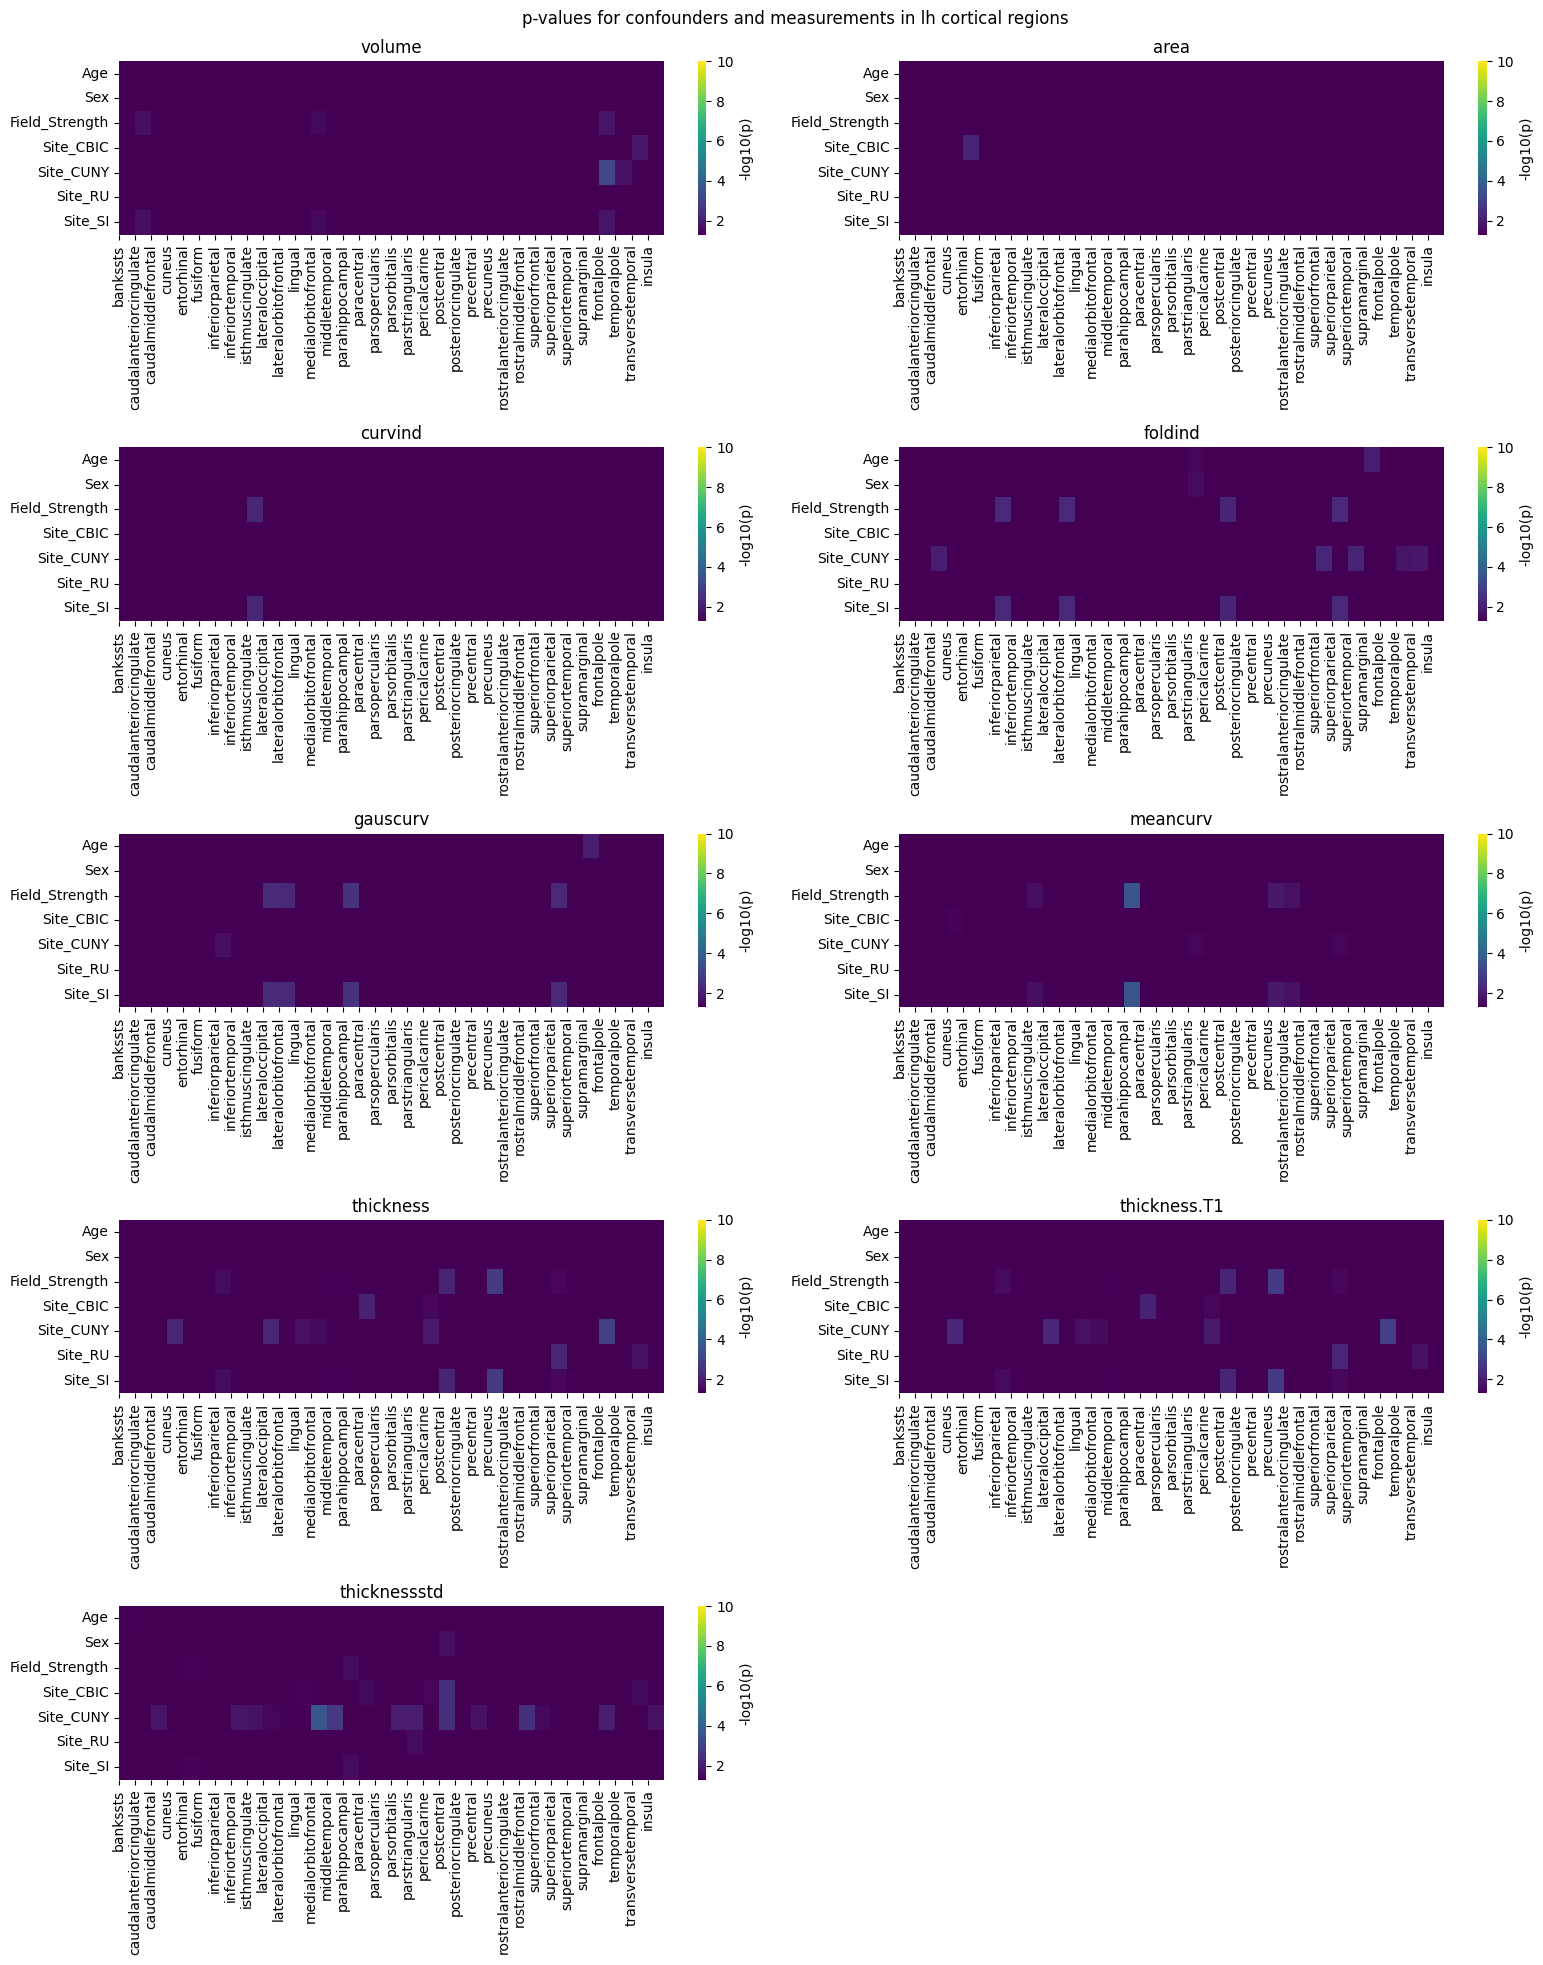

In [76]:
plt.figure(1,(16,20))

for index in range(len(aparc_msnts)):
    P = pd.DataFrame.from_dict(f_dicts[index], orient='index', columns=aparc_roi_labels)
    P = P.replace(0, 1e-15)
    plt.subplot(5,2,index+1)
    sns.heatmap(-np.log10(P), cmap='viridis', vmin=-np.log10(0.05), vmax=10, fmt=".2f", cbar_kws={'label': '-log10(p)'})
    plt.xticks(range(len(aparc_roi_labels)),aparc_roi_labels)
    plt.title(f"{aparc_msnts[index]}")

plt.suptitle("p-values for confounders and measurements in lh cortical regions\n")
plt.tight_layout()

plt.savefig(f'{plot_path}pvalues_confounder_aparc_lh.png', bbox_inches='tight')

rh

In [35]:
f_dicts = []

for f in aparc_msnts:
    
    f_dict = {}
    Y = load_feature_subset(features, 'aparc_rh', [f], -1)
    Y = standardize(Y)
    
    for c in C_:
        c_list = []
        
        for roi in Y:
            c_ =  sm.add_constant(C_[c])
            est = sm.OLS(Y[roi], c_)
            est = est.fit(disp=0)
            c_list.append(est.pvalues[1])
    
        f_dict[c] = c_list
    f_dicts.append(f_dict)

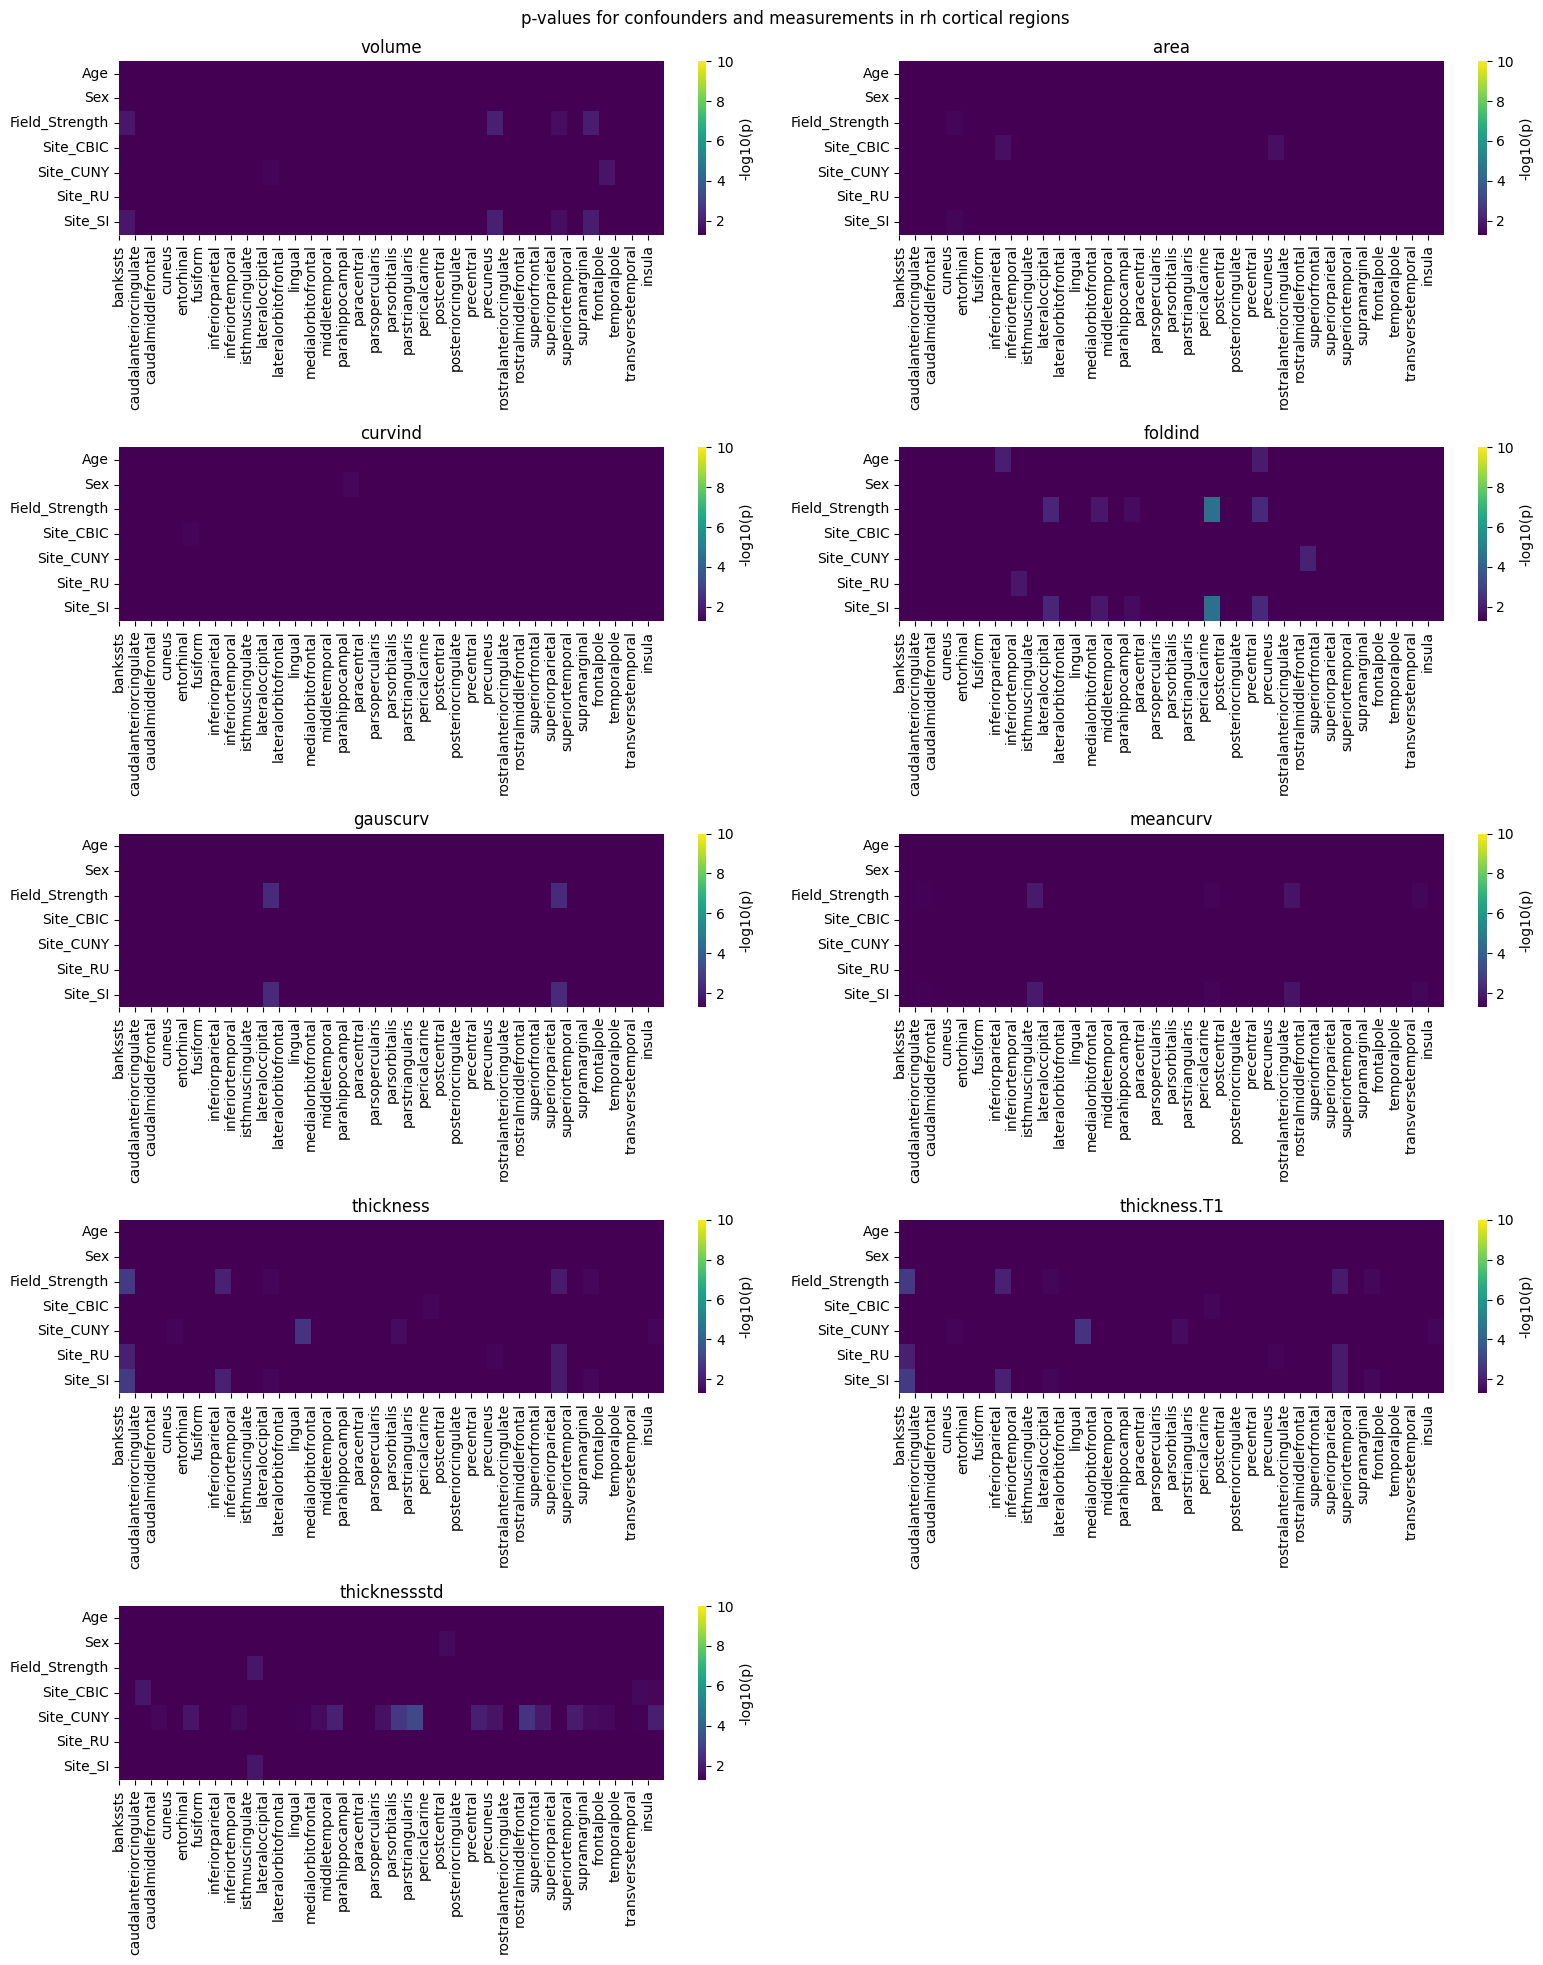

In [36]:
plt.figure(1,(16,20))

for index in range(len(aparc_msnts)):
    P = pd.DataFrame.from_dict(f_dicts[index], orient='index', columns=aparc_roi_labels)
    P = P.replace(0, 1e-15)
    plt.subplot(5,2,index+1)
    sns.heatmap(-np.log10(P), cmap='viridis', vmin=-np.log10(0.05), vmax=10, fmt=".2f", cbar_kws={'label': '-log10(p)'})
    plt.xticks(range(len(aparc_roi_labels)),aparc_roi_labels)
    plt.title(f"{aparc_msnts[index]}")

plt.suptitle("p-values for confounders and measurements in rh cortical regions\n")
plt.tight_layout()

plt.savefig(f'{plot_path}pvalues_confounder_aparc_rh.png',bbox_inches='tight')

### 1.3. P-values for diagnoses
Plot significant p-values for diagnoses (deconfounded) explaining features. For every combination of diagnosis and feature (univariate setting), a linear regression model is fitted. Input and output variables are standardized prior to model fitting. The p-values are derived from the regression coefficients using a t-test. The feature classes include global, aseg, aparc_lh and aparc_rh.

In [47]:
D_ = standardize(D_deconf)

In [48]:
aseg_roi_labels, aparc_roi_labels = load_roi_labels()

#### 1.3.1. Global features

In [50]:
p_dict = {}

for d in D_:
    
    d_list = []

    for f in global_msnts:
        y = load_feature_subset(features, 'global', [f])
        y = standardize(y) # standardize freesurfer variables
        d_ =  sm.add_constant(D_[d])
        est = sm.OLS(y, d_) # y (FreeSurfer feature) is the depenent variable and d_ (diangosis) is the independent variable
        est = est.fit(disp=0)
        d_list.append(est.pvalues[1])

    p_dict[d] = d_list

In [51]:
P = pd.DataFrame.from_dict(p_dict, orient='index', columns=global_msnts)
# Replace zero values with small positive constant to avoid numerical problems
P = P.replace(0, 1e-15)

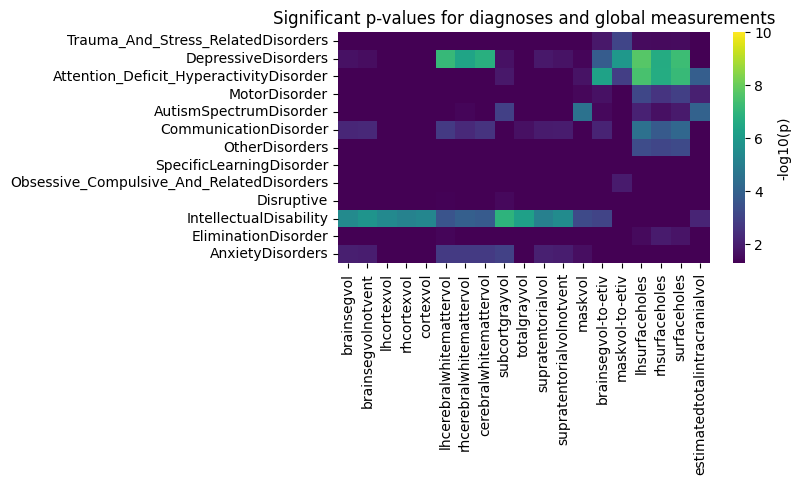

In [52]:
# Plot
plt.figure(1,(6,3))
sns.heatmap(-np.log10(P), cmap='viridis', vmin=-np.log10(0.05), vmax=10, fmt=".2f", cbar_kws={'label': '-log10(p)'})
plt.title(r"Significant p-values for diagnoses and global measurements")
plt.savefig(plot_path + 'pvalues_diagnoses_global.png',bbox_inches='tight')

#### 1.3.2. Subcortical features

In [77]:
f_dicts = []

for f in aseg_msnts:
    
    f_dict = {}
    Y = load_feature_subset(features, 'aseg',[f],-1)
    Y = standardize(Y) # standardize freesurfer variables
    
    for d in D_:
        d_list = []
        
        for roi in Y:
            d_ =  sm.add_constant(D_[d])
            est = sm.OLS(Y[roi], d_)
            est = est.fit(disp=0)
            d_list.append(est.pvalues[1])
            
    
        f_dict[d] = d_list
    f_dicts.append(f_dict)

In [78]:
aseg_roi_labels_copy = aseg_roi_labels.copy()
to_remove = ['left-wm-hypointensities','right-wm-hypointensities','left-non-wm-hypointensities','right-non-wm-hypointensities']
[aseg_roi_labels_copy.remove(x) for x in to_remove]

[None, None, None, None]

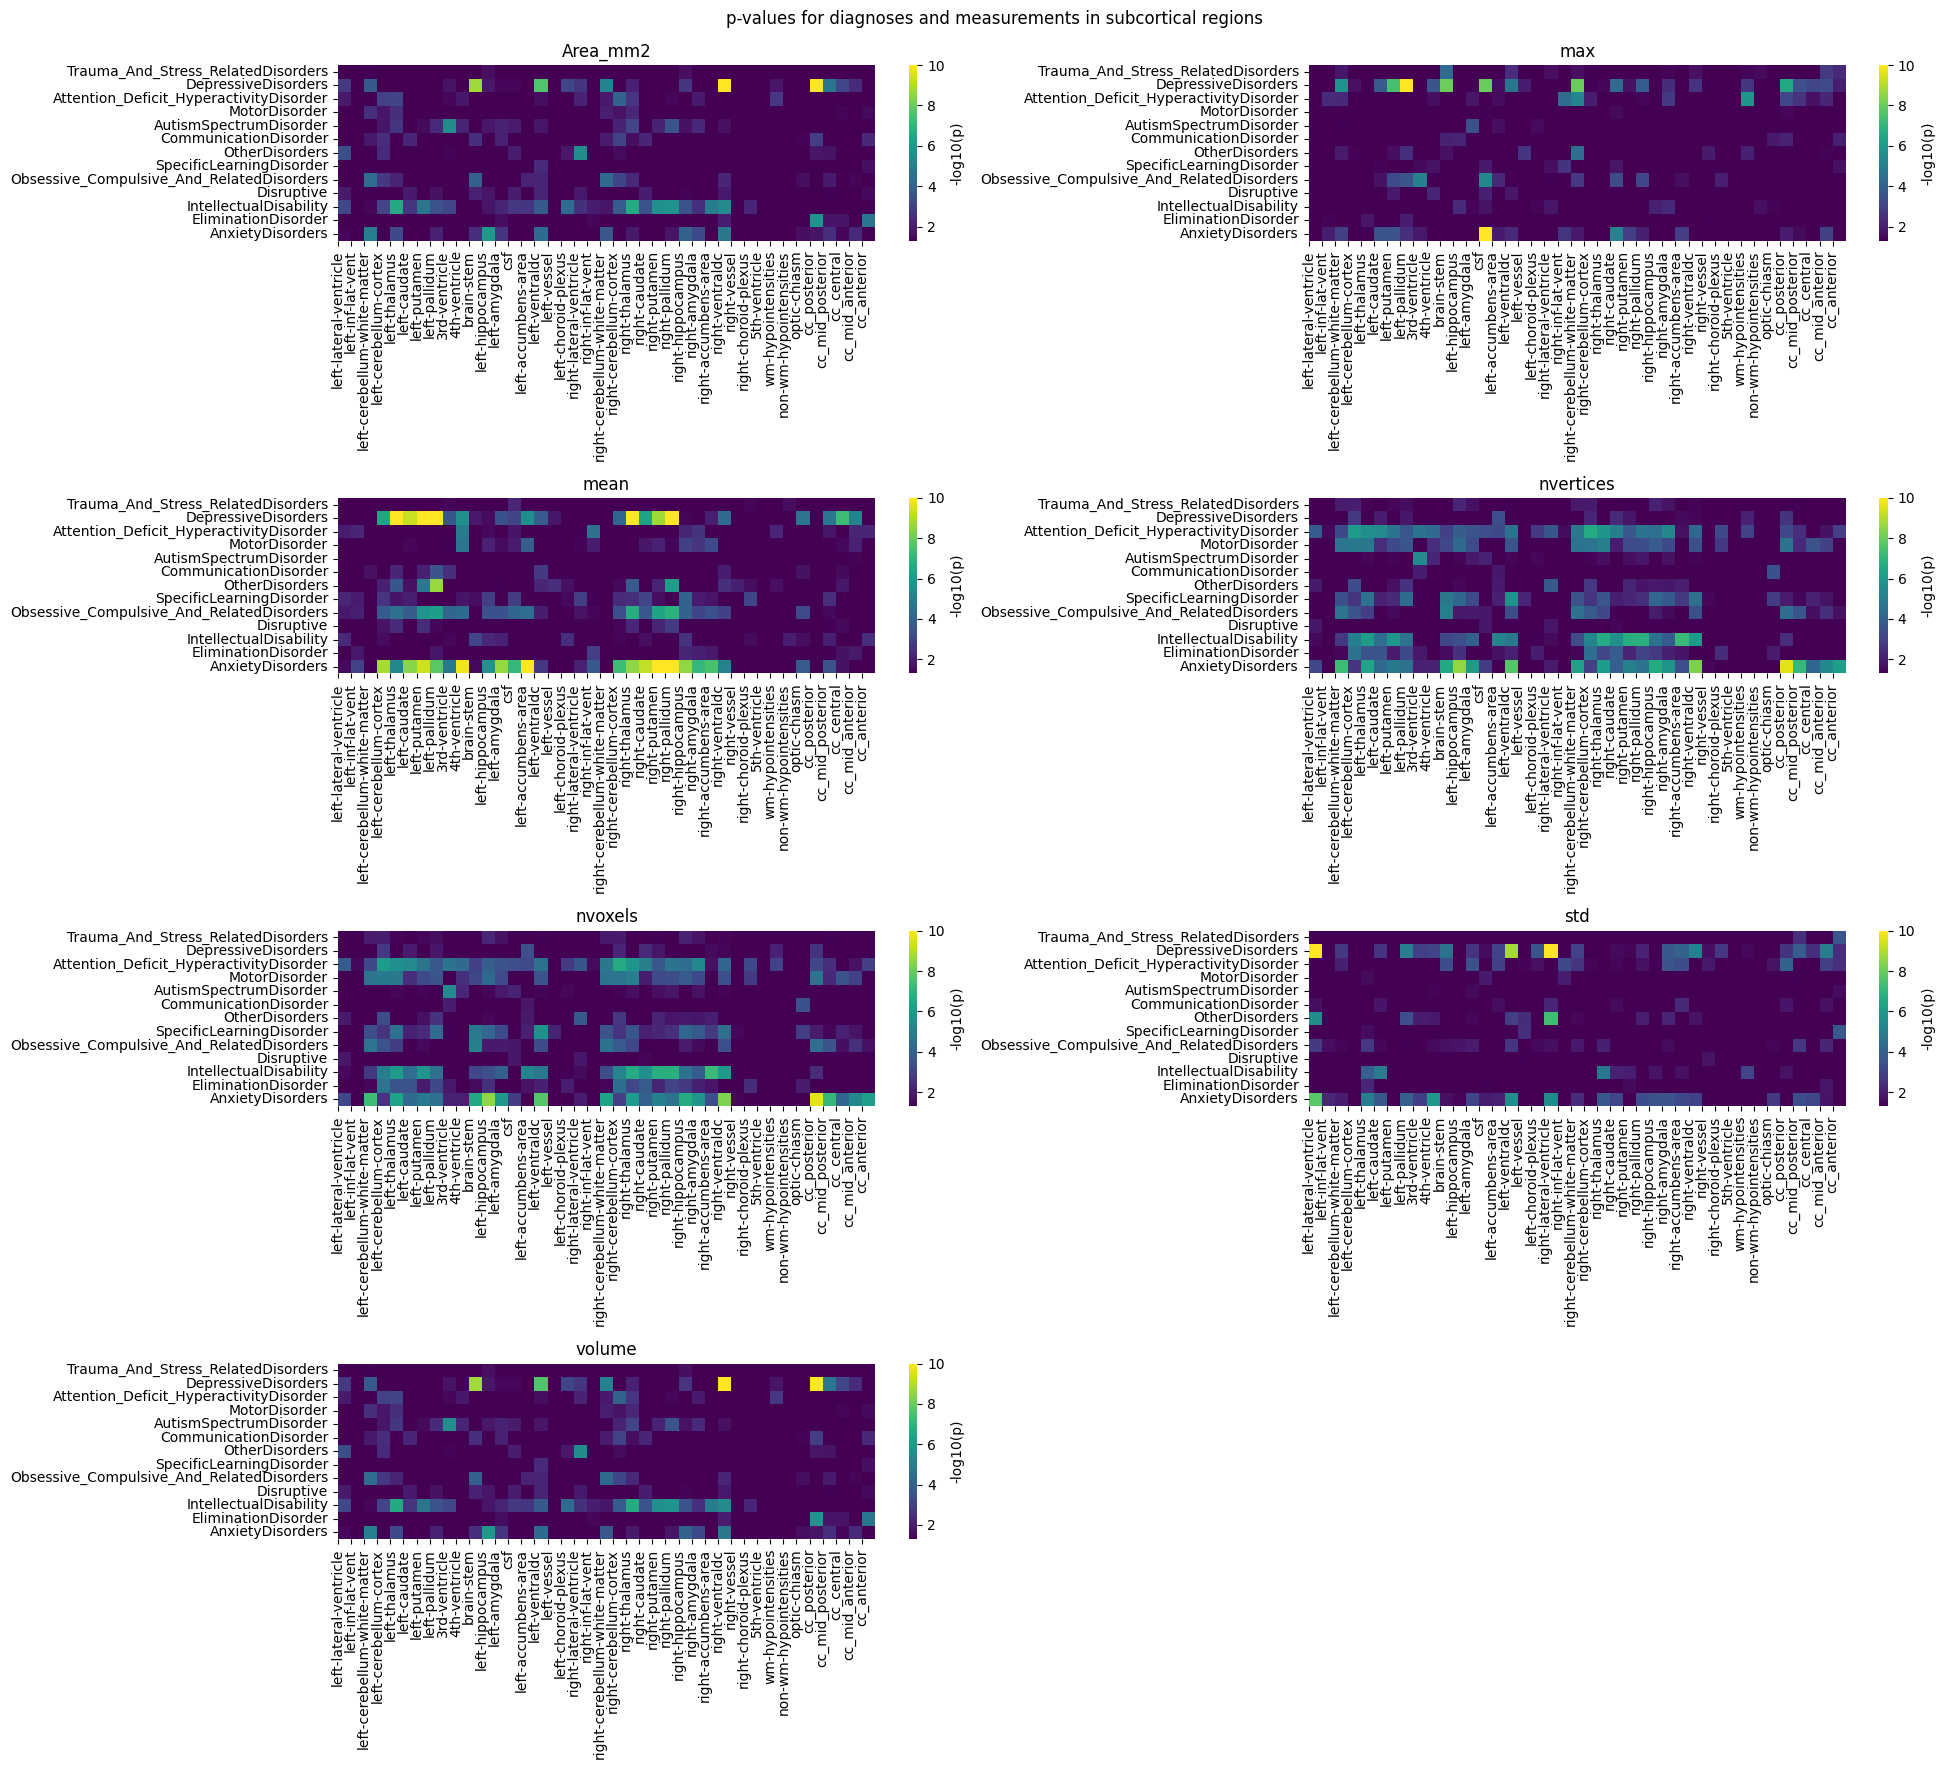

In [79]:
plt.figure(1,(20,18))

for index in range(len(aseg_msnts)):
    P = pd.DataFrame.from_dict(f_dicts[index], orient='index', columns=aseg_roi_labels)
    P = P.replace(0, 1e-15)
    P = P.drop(to_remove, axis=1)
    plt.subplot(4,2,index+1)
    sns.heatmap(-np.log10(P), cmap='viridis', vmin=-np.log10(0.05), vmax=10, fmt=".2f", cbar_kws={'label': '-log10(p)'})
    plt.xticks(range(len(aseg_roi_labels_copy)), aseg_roi_labels_copy)
    plt.title(f"{aseg_msnts[index]}")

plt.suptitle("p-values for diagnoses and measurements in subcortical regions\n")
plt.tight_layout()

plt.savefig(f'{plot_path}pvalues_diagnoses_aseg.png', bbox_inches='tight')

#### 1.3.3. Cortical features

lh

In [56]:
f_dicts = []

for f in aparc_msnts:
    
    f_dict = {}
    Y = load_feature_subset(features, 'aparc_lh', [f], -1)
    Y = standardize(Y)
    
    for d in D_:
        d_list = []
        
        for roi in Y:
            d_ =  sm.add_constant(D_[d])
            est = sm.OLS(Y[roi], d_) 
            est = est.fit(disp=0)
            d_list.append(est.pvalues[1])
    
        f_dict[d] = d_list
    f_dicts.append(f_dict)


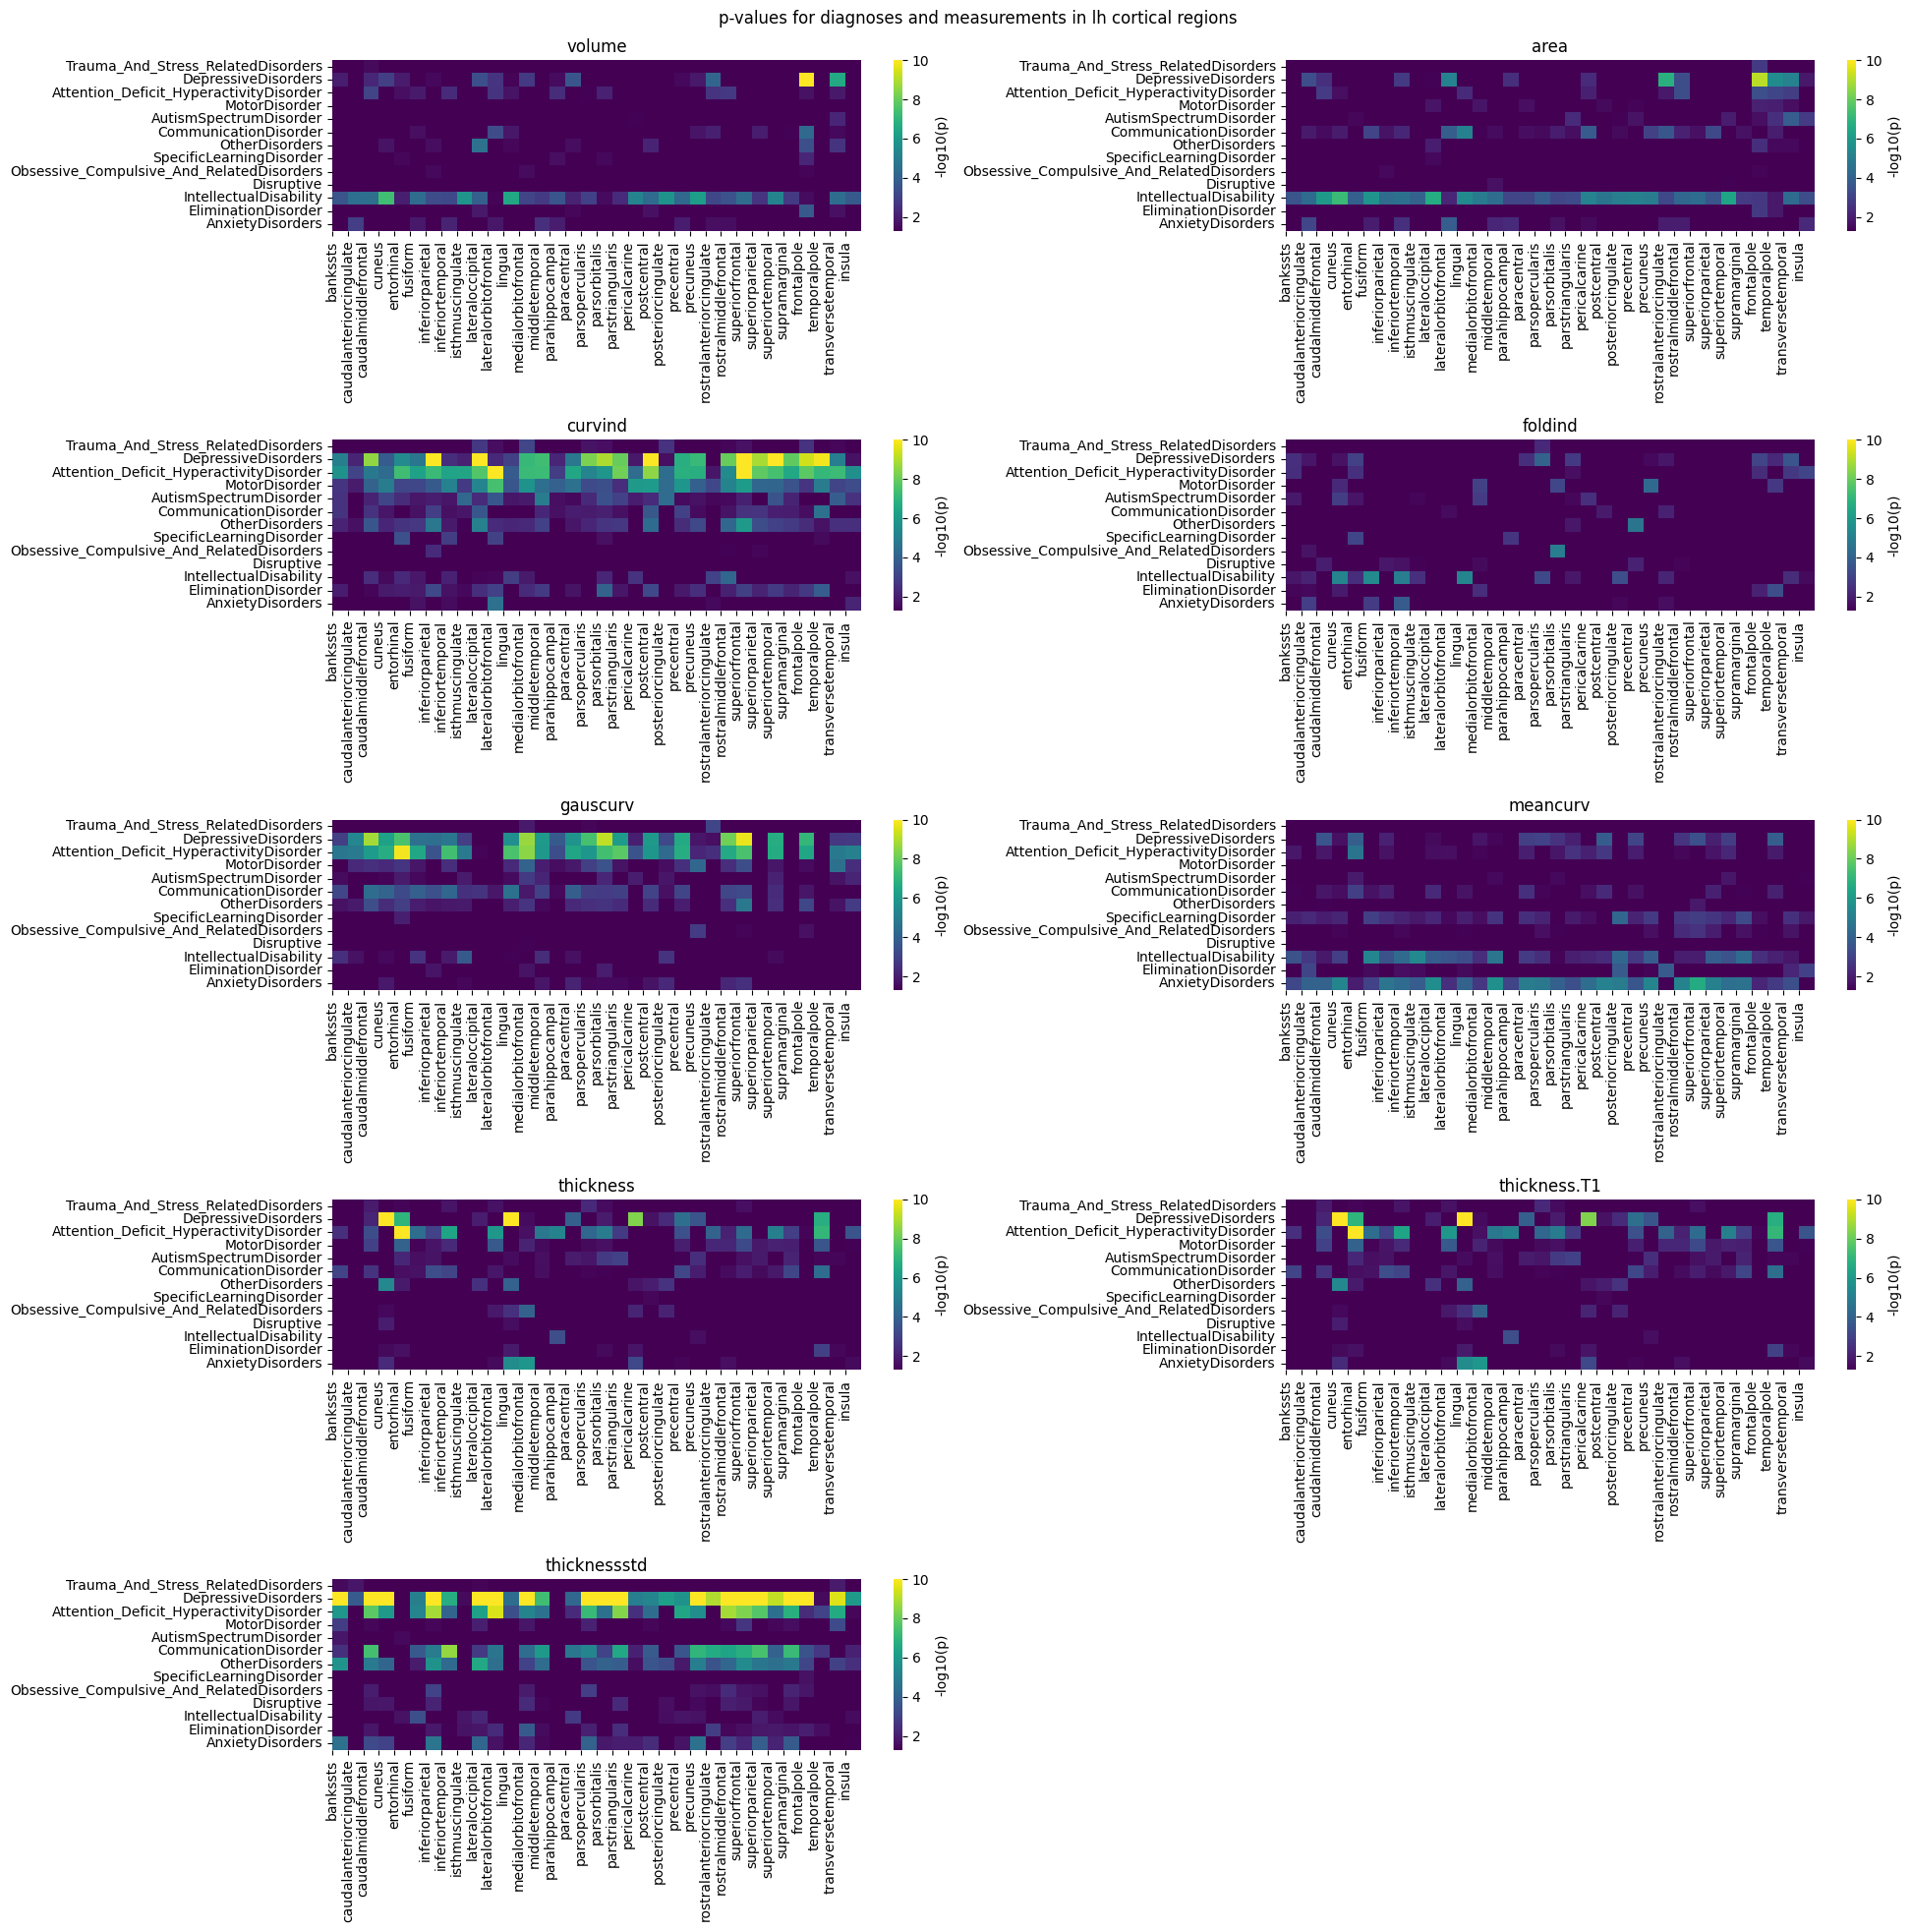

In [57]:
plt.figure(1,(20,20))

for index in range(len(aparc_msnts)):
    P = pd.DataFrame.from_dict(f_dicts[index], orient='index', columns=aparc_roi_labels)
    P = P.replace(0, 1e-15)
    plt.subplot(5,2,index+1)
    sns.heatmap(-np.log10(P), cmap='viridis', vmin=-np.log10(0.05), vmax=10, fmt=".2f", cbar_kws={'label': '-log10(p)'})
    plt.xticks(range(len(aparc_roi_labels)),aparc_roi_labels)
    plt.title(f"{aparc_msnts[index]}")

plt.suptitle("p-values for diagnoses and measurements in lh cortical regions\n")
plt.tight_layout()

plt.savefig(f'{plot_path}pvalues_diagnoses_aparc_lh.png', bbox_inches='tight')

rh

In [58]:
f_dicts = []

for f in aparc_msnts:
    
    f_dict = {}
    Y = load_feature_subset(features, 'aparc_rh', [f], -1)
    Y = standardize(Y)
    
    for d in D_:
        d_list = []
        
        for roi in Y:
            d_ =  sm.add_constant(D_[d])
            est = sm.OLS(Y[roi], d_)
            est = est.fit(disp=0)
            d_list.append(est.pvalues[1])
    
        f_dict[d] = d_list
    f_dicts.append(f_dict)

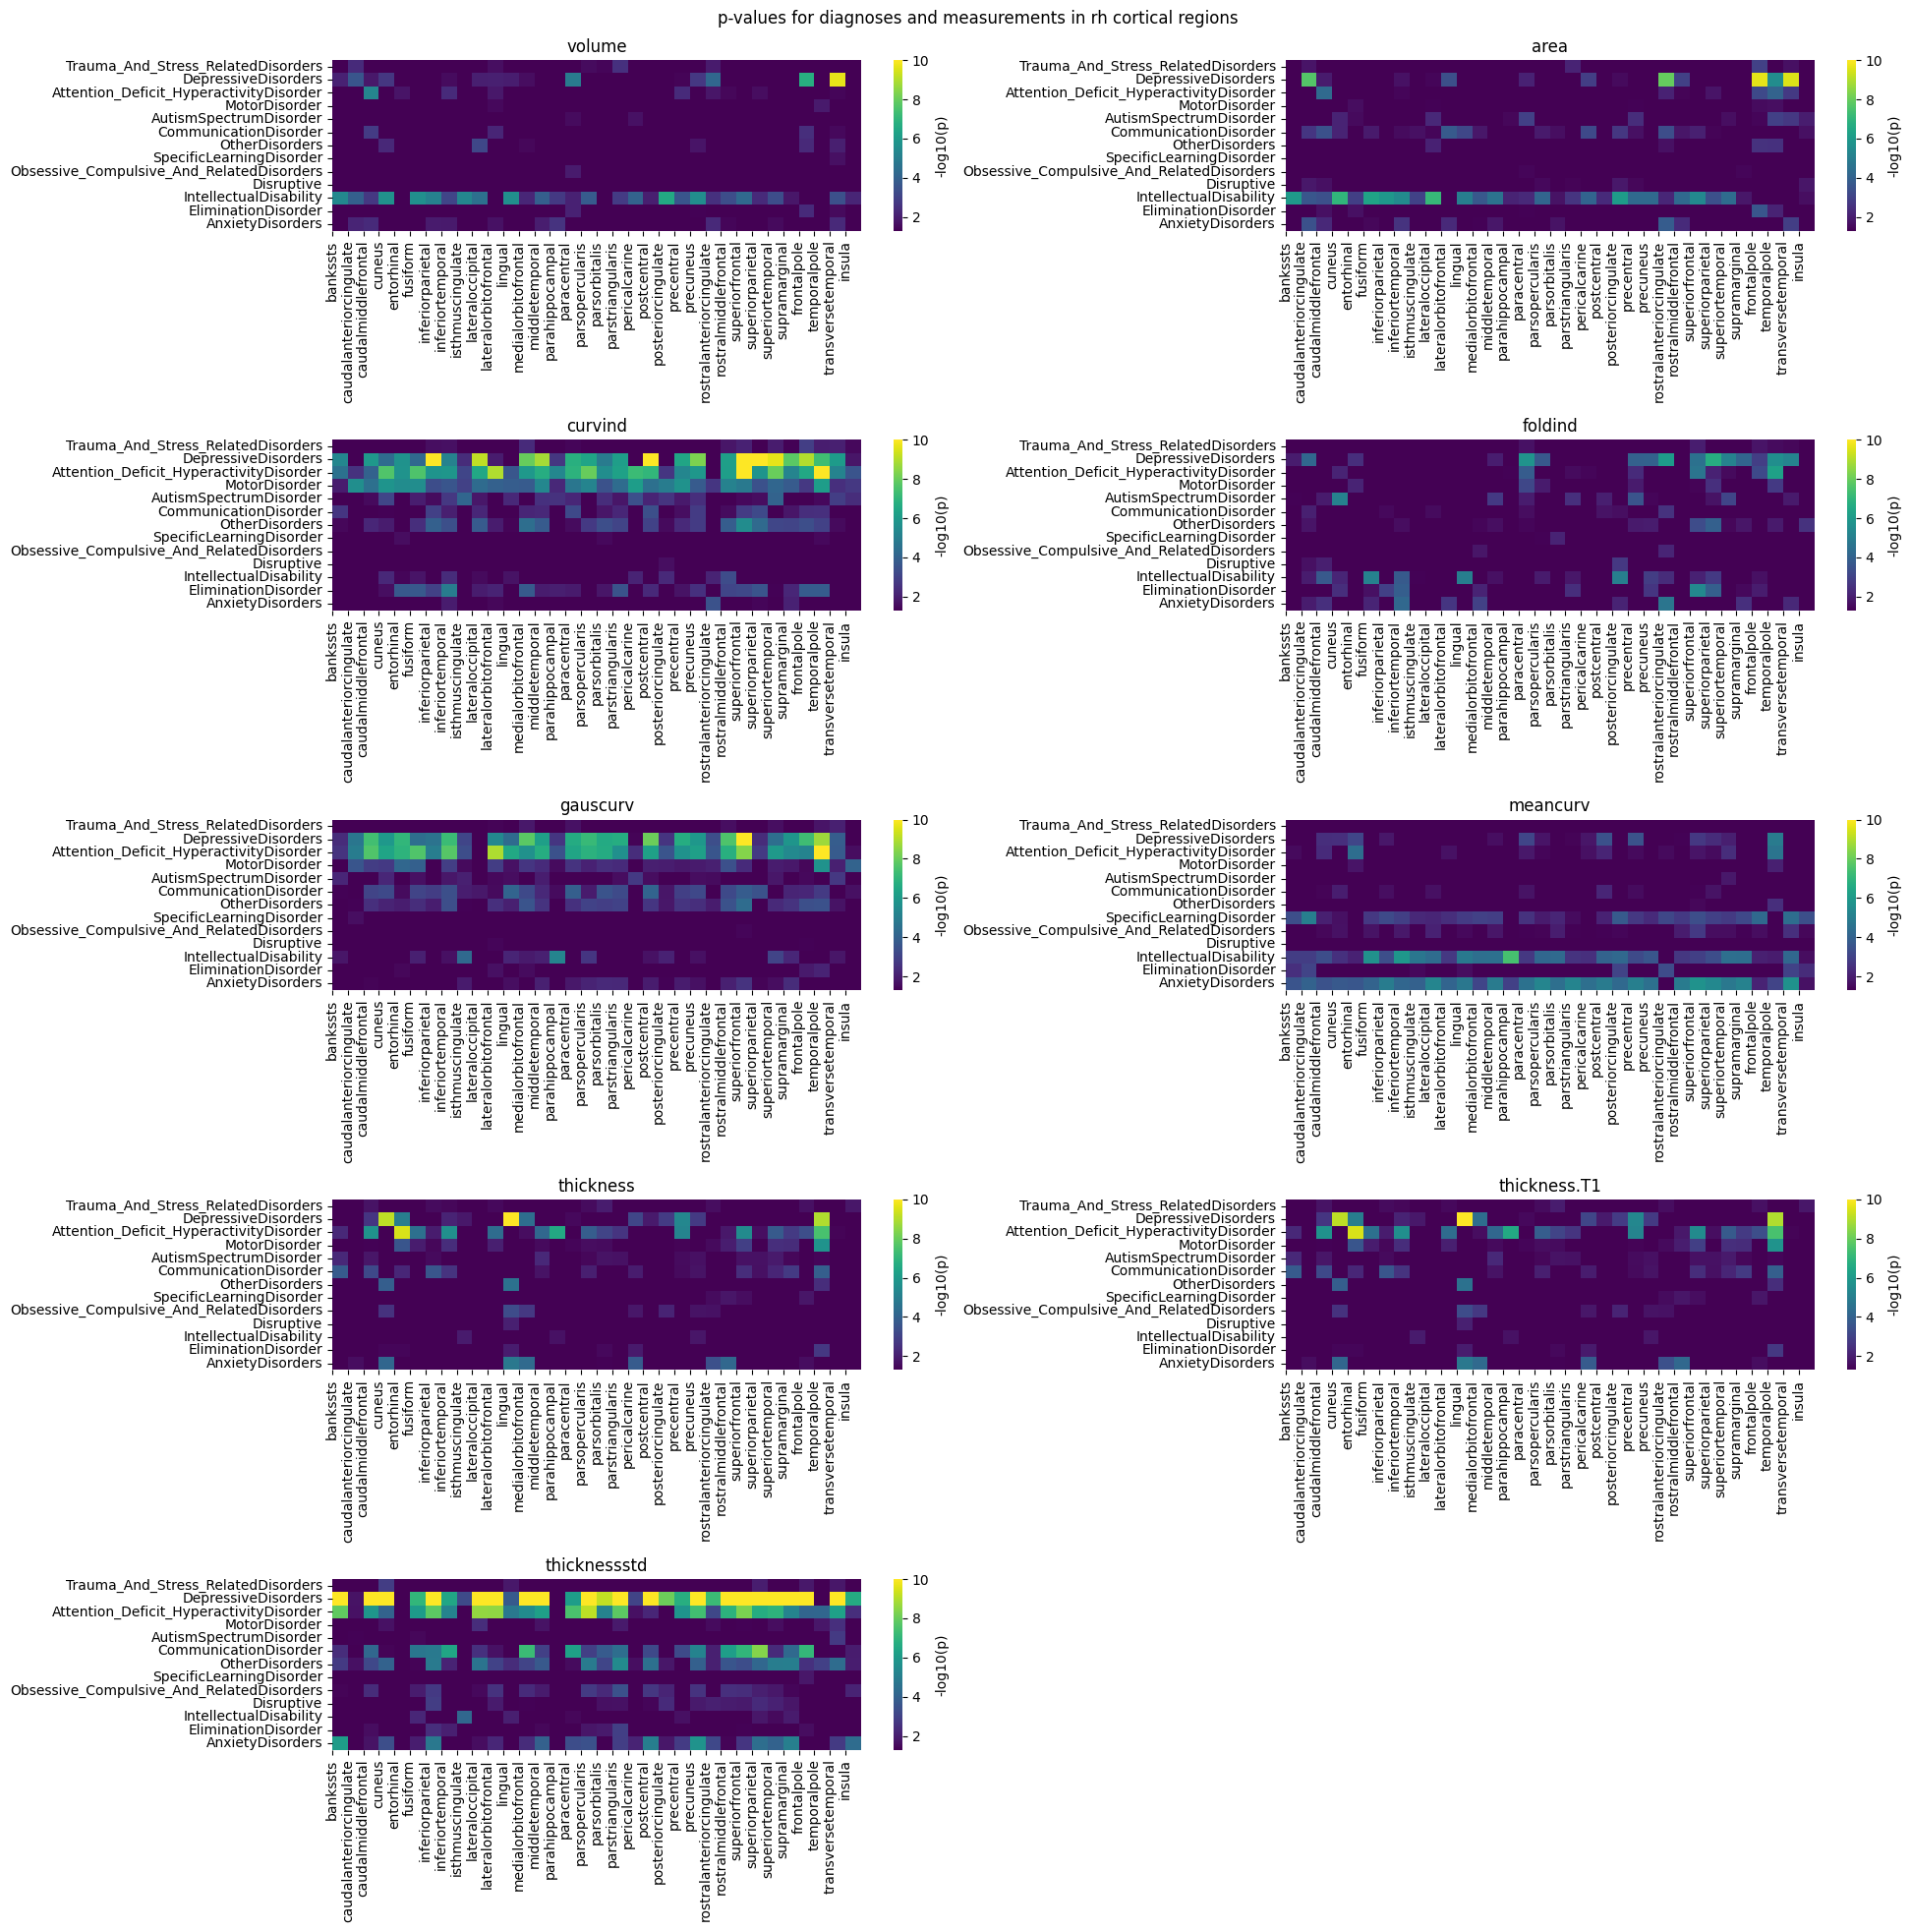

In [59]:
plt.figure(1,(20,20))

for index in range(len(aparc_msnts)):
    P = pd.DataFrame.from_dict(f_dicts[index], orient='index', columns=aparc_roi_labels)
    P = P.replace(0, 1e-15)
    plt.subplot(5,2,index+1)
    sns.heatmap(-np.log10(P), cmap='viridis', vmin=-np.log10(0.05), vmax=10, fmt=".2f", cbar_kws={'label': '-log10(p)'})
    plt.xticks(range(len(aparc_roi_labels)),aparc_roi_labels)
    plt.title(f"{aparc_msnts[index]}")

plt.suptitle("p-values for diagnoses and measurements in rh cortical regions\n")
plt.tight_layout()

plt.savefig(f'{plot_path}pvalues_diagnoses_aparc_rh.png', bbox_inches='tight')

### 1.4. Predicting confounders with morphometric features
Use FreeSurfer features to predict confounders (discretized) using logistic regression and gradient boosting. The evaluation scores based on AUROC and balanced accuracy quantify possible associations. 

Only use subcortical and cortical features

In [60]:
F2 = remove_zero_features(load_feature_subset(features, 'aseg', aseg_msnts, -1))
F3l = remove_zero_features(load_feature_subset(features, 'aparc_lh', aparc_msnts, -1))
F3r = remove_zero_features(load_feature_subset(features, 'aparc_rh', aparc_msnts, -1))

Standardize

In [61]:
F_ = standardize(pd.concat([F2, F3l, F3r], axis=1))

Load discretized confounders

In [62]:
C = load_confounders(subject_data, discrete=True)
C = C.iloc[:,1:]

Split into train and holdout set

In [63]:
# Split dataset into train and test (holdout) set
X_train, X_test, Y_train, Y_test = train_test_split(F_, C, test_size=0.25, random_state=0)
print(f"Number of samples in training set: {len(X_train)}")
print(f"Number of samples in test set: {len(X_test)}")

Number of samples in training set: 2111
Number of samples in test set: 704


#### 1.4.1. Logistic regression

In [19]:
clf = LogisticRegression(max_iter=10000)

In [38]:
for l in C.columns:
    print(f"{l}")
    
    cv_scores = cross_val_score(clf, X_train, Y_train[l], cv=5, scoring='roc_auc')
    clf_ = clf.fit(X_train, Y_train[l])
    y_prob = clf_.predict_proba(X_test)
    print("roc_auc: ".ljust(20) + f"{cv_scores.mean():.2f} (cv)" + "\t" + f"{roc_auc_score(Y_test[l], y_prob[:,1]):.2f} (test)")

    cv_scores = cross_val_score(clf, X_train, Y_train[l], cv=5, scoring='balanced_accuracy')
    clf_ = clf.fit(X_train, Y_train[l])
    y_pred = clf_.predict(X_test)
    print("balanced_accuracy: ".ljust(20) + f"{cv_scores.mean():.2f} (cv)" + "\t" + f"{balanced_accuracy_score(Y_test[l], y_pred):.2f} (test)\n")

Sex
roc_auc:            0.47 (cv)	0.52 (test)
balanced_accuracy:  0.49 (cv)	0.53 (test)

Site_CBIC
roc_auc:            0.50 (cv)	0.50 (test)
balanced_accuracy:  0.50 (cv)	0.50 (test)

Site_CUNY
roc_auc:            0.50 (cv)	0.51 (test)
balanced_accuracy:  0.49 (cv)	0.51 (test)

Site_RU
roc_auc:            0.50 (cv)	0.52 (test)
balanced_accuracy:  0.50 (cv)	0.50 (test)

Site_SI
roc_auc:            0.48 (cv)	0.53 (test)
balanced_accuracy:  0.48 (cv)	0.49 (test)

Cohort_2
roc_auc:            0.52 (cv)	0.49 (test)
balanced_accuracy:  0.52 (cv)	0.48 (test)

Cohort_3
roc_auc:            0.50 (cv)	0.51 (test)
balanced_accuracy:  0.52 (cv)	0.50 (test)

Cohort_4
roc_auc:            0.49 (cv)	0.44 (test)
balanced_accuracy:  0.50 (cv)	0.46 (test)

Cohort_5
roc_auc:            0.48 (cv)	0.47 (test)
balanced_accuracy:  0.49 (cv)	0.50 (test)

Cohort_6
roc_auc:            0.51 (cv)	0.53 (test)
balanced_accuracy:  0.52 (cv)	0.50 (test)

Field_Strength_1.5
roc_auc:            0.48 (cv)	0.53 (test)
bala

#### 1.4.2. Gradient boosting

In [35]:
clf = HistGradientBoostingClassifier()

In [36]:
for l in C.columns:
    print(f"{l}")
    
    cv_scores = cross_val_score(clf, X_train, Y_train[l], cv=5, scoring='roc_auc')
    clf_ = clf.fit(X_train, Y_train[l])
    y_prob = clf_.predict_proba(X_test)
    print("roc_auc: ".ljust(20) + f"{cv_scores.mean():.2f} (cv)" + "\t" + f"{roc_auc_score(Y_test[l], y_prob[:,1]):.2f} (test)")

    cv_scores = cross_val_score(clf, X_train, Y_train[l], cv=5, scoring='balanced_accuracy')
    clf_ = clf.fit(X_train, Y_train[l])
    y_pred = clf_.predict(X_test)
    print("balanced_accuracy: ".ljust(20) + f"{cv_scores.mean():.2f} (cv)" + "\t" + f"{balanced_accuracy_score(Y_test[l], y_pred):.2f} (test)\n")

Sex
roc_auc:            0.48 (cv)	0.48 (test)
balanced_accuracy:  0.49 (cv)	0.49 (test)

Site_CBIC
roc_auc:            0.48 (cv)	0.49 (test)
balanced_accuracy:  0.48 (cv)	0.48 (test)

Site_CUNY
roc_auc:            0.49 (cv)	0.56 (test)
balanced_accuracy:  0.50 (cv)	0.50 (test)

Site_RU
roc_auc:            0.49 (cv)	0.49 (test)
balanced_accuracy:  0.50 (cv)	0.51 (test)

Site_SI
roc_auc:            0.53 (cv)	0.59 (test)
balanced_accuracy:  0.50 (cv)	0.50 (test)

Cohort_2
roc_auc:            0.50 (cv)	0.52 (test)
balanced_accuracy:  0.51 (cv)	0.51 (test)

Cohort_3
roc_auc:            0.51 (cv)	0.50 (test)
balanced_accuracy:  0.50 (cv)	0.50 (test)

Cohort_4
roc_auc:            0.47 (cv)	0.45 (test)
balanced_accuracy:  0.50 (cv)	0.50 (test)

Cohort_5
roc_auc:            0.45 (cv)	0.48 (test)
balanced_accuracy:  0.50 (cv)	0.50 (test)

Cohort_6
roc_auc:            0.54 (cv)	0.49 (test)
balanced_accuracy:  0.50 (cv)	0.50 (test)

Field_Strength_1.5
roc_auc:            0.53 (cv)	0.59 (test)
bala